# **New York City Yellow Taxi Data**

## Objective
In this case study you will be learning exploratory data analysis (EDA) with the help of a dataset on yellow taxi rides in New York City. This will enable you to understand why EDA is an important step in the process of data science and machine learning.

## **Problem Statement**
As an analyst at an upcoming taxi operation in NYC, you are tasked to use the 2023 taxi trip data to uncover insights that could help optimise taxi operations. The goal is to analyse patterns in the data that can inform strategic decisions to improve service efficiency, maximise revenue, and enhance passenger experience.

## Tasks
You need to perform the following steps for successfully completing this assignment:
1. Data Loading
2. Data Cleaning
3. Exploratory Analysis: Bivariate and Multivariate
4. Creating Visualisations to Support the Analysis
5. Deriving Insights and Stating Conclusions

---

**NOTE:** The marks given along with headings and sub-headings are cumulative marks for those particular headings/sub-headings.<br>

The actual marks for each task are specified within the tasks themselves.

For example, marks given with heading *2* or sub-heading *2.1* are the cumulative marks, for your reference only. <br>

The marks you will receive for completing tasks are given with the tasks.

Suppose the marks for two tasks are: 3 marks for 2.1.1 and 2 marks for 3.2.2, or
* 2.1.1 [3 marks]
* 3.2.2 [2 marks]

then, you will earn 3 marks for completing task 2.1.1 and 2 marks for completing task 3.2.2.


---

## Data Understanding
The yellow taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is stored in Parquet format (*.parquet*). The dataset is from 2009 to 2024. However, for this assignment, we will only be using the data from 2023.

The data for each month is present in a different parquet file. You will get twelve files for each of the months in 2023.

The data was collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers like vendors and taxi hailing apps. <br>

You can find the link to the TLC trip records page here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page

###  Data Description
You can find the data description here: [Data Dictionary](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

**Trip Records**



|Field Name       |description |
|:----------------|:-----------|
| VendorID | A code indicating the TPEP provider that provided the record. <br> 1= Creative Mobile Technologies, LLC; <br> 2= VeriFone Inc. |
| tpep_pickup_datetime | The date and time when the meter was engaged.  |
| tpep_dropoff_datetime | The date and time when the meter was disengaged.   |
| Passenger_count | The number of passengers in the vehicle. <br> This is a driver-entered value. |
| Trip_distance | The elapsed trip distance in miles reported by the taximeter. |
| PULocationID | TLC Taxi Zone in which the taximeter was engaged |
| DOLocationID | TLC Taxi Zone in which the taximeter was disengaged |
|RateCodeID |The final rate code in effect at the end of the trip.<br> 1 = Standard rate <br> 2 = JFK <br> 3 = Newark <br>4 = Nassau or Westchester <br>5 = Negotiated fare <br>6 = Group ride |
|Store_and_fwd_flag |This flag indicates whether the trip record was held in vehicle memory before sending to the vendor, aka “store and forward,” because the vehicle did not have a connection to the server.  <br>Y= store and forward trip <br>N= not a store and forward trip |
|Payment_type| A numeric code signifying how the passenger paid for the trip. <br> 1 = Credit card <br>2 = Cash <br>3 = No charge <br>4 = Dispute <br>5 = Unknown <br>6 = Voided trip |
|Fare_amount| The time-and-distance fare calculated by the meter. <br>Extra Miscellaneous extras and surcharges.  Currently, this only includes the 0.50 and 1 USD rush hour and overnight charges. |
|MTA_tax |0.50 USD MTA tax that is automatically triggered based on the metered rate in use. |
|Improvement_surcharge | 0.30 USD improvement surcharge assessed trips at the flag drop. The improvement surcharge began being levied in 2015. |
|Tip_amount |Tip amount – This field is automatically populated for credit card tips. Cash tips are not included. |
| Tolls_amount | Total amount of all tolls paid in trip.  |
| total_amount | The total amount charged to passengers. Does not include cash tips. |
|Congestion_Surcharge |Total amount collected in trip for NYS congestion surcharge. |
| Airport_fee | 1.25 USD for pick up only at LaGuardia and John F. Kennedy Airports|

Although the amounts of extra charges and taxes applied are specified in the data dictionary, you will see that some cases have different values of these charges in the actual data.

**Taxi Zones**

Each of the trip records contains a field corresponding to the location of the pickup or drop-off of the trip, populated by numbers ranging from 1-263.

These numbers correspond to taxi zones, which may be downloaded as a table or map/shapefile and matched to the trip records using a join.

This is covered in more detail in later sections.

---

## **1** Data Preparation

<font color = red>[5 marks]</font> <br>

### Import Libraries

In [1]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Import the libraries you will be using for analysis
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns


In [5]:
# Recommended versions
# numpy version: 1.26.4
# pandas version: 2.2.2
# matplotlib version: 3.10.0
# seaborn version: 0.13.2


# Check versions
print("numpy version:", np.__version__)
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)

numpy version: 1.26.4
pandas version: 2.2.2
matplotlib version: 3.10.0
seaborn version: 0.13.2


In [6]:
!pip install matplotlib==3.10.0

### **1.1** Load the dataset
<font color = red>[5 marks]</font> <br>

You will see twelve files, one for each month.

To read parquet files with Pandas, you have to follow a similar syntax as that for CSV files.

`df = pd.read_parquet('file.parquet')`

How many rows are there? Do you think handling such a large number of rows is computationally feasible when we have to combine the data for all twelve months into one?

To handle this, we need to sample a fraction of data from each of the files. How to go about that? Think of a way to select only some portion of the data from each month's file that accurately represents the trends.

#### Sampling the Data
> One way is to take a small percentage of entries for pickup in every hour of a date. So, for all the days in a month, we can iterate through the hours and select 5% values randomly from those. Use `tpep_pickup_datetime` for this. Separate date and hour from the datetime values and then for each date, select some fraction of trips for each of the 24 hours.

To sample data, you can use the `sample()` method. Follow this syntax:

```Python
# sampled_data is an empty DF to keep appending sampled data of each hour
# hour_data is the DF of entries for an hour 'X' on a date 'Y'

sample = hour_data.sample(frac = 0.05, random_state = 42)
# sample 0.05 of the hour_data
# random_state is just a seed for sampling, you can define it yourself

sampled_data = pd.concat([sampled_data, sample]) # adding data for this hour to the DF
```

This *sampled_data* will contain 5% values selected at random from each hour.

Note that the code given above is only the part that will be used for sampling and not the complete code required for sampling and combining the data files.

Keep in mind that you sample by date AND hour, not just hour. (Why?)

---

**1.1.1** <font color = red>[5 marks]</font> <br>
Figure out how to sample and combine the files.

**Note:** It is not mandatory to use the method specified above. While sampling, you only need to make sure that your sampled data represents the overall data of all the months accurately.

In [392]:
# Sample the data
# It is recommmended to not load all the files at once to avoid memory overload

In [394]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# Take a small percentage of entries from each hour of every date.
# Iterating through the monthly data:
#   read a month file -> day -> hour: append sampled data -> move to next hour -> move to next day after 24 hours -> move to next month file
# Create a single dataframe for the year combining all the monthly data

# Select the folder having data files
import os

# Select the folder having data files
os.chdir(r"C:\Users\qaspe\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\trip_records")

# Create a list of all the twelve files to read
file_list = os.listdir()

# initialise an empty dataframe
sampled_df = pd.DataFrame()


# iterate through the list of files and sample one by one:
for file_name in file_list:
    try:
        # file path for the current file
        file_path = os.path.join(os.getcwd(),file_name)

        # Reading the current file
        df = pd.read_parquet(file_path)

        df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])

        df['date'] = df['tpep_pickup_datetime'].dt.date
        df['hour'] = df['tpep_pickup_datetime'].dt.hour

        # We will store the sampled data for the current date in this df by appending the sampled data from each hour to this
        # After completing iteration through each date, we will append this data to the final dataframe.
        sampled_data = pd.DataFrame()

        # Loop through dates and then loop through every hour of each date
        for date in df['date'].unique():
            date_data = df[df['date'] == date]
            
            # Iterate through each hour of the selected date
            for hour in range(24):
                hour_data = date_data[date_data['hour'] == hour]

                # Sample 1% of the hourly data randomly
                if not hour_data.empty:
                    sample = hour_data.sample(frac=0.0075, random_state=42)

                # add data of this hour to the dataframe
                    sampled_data = pd.concat([sampled_data, sample])

        # Concatenate the sampled data of all the dates to a single dataframe
        sampled_df = pd.concat([sampled_df, sampled_data])


    except Exception as e:
        print(f"Error reading file {file_name}: {e}")

Error reading file Final_2023_data.csv: Could not open Parquet input source '<Buffer>': Parquet magic bytes not found in footer. Either the file is corrupted or this is not a parquet file.


After combining the data files into one DataFrame, convert the new DataFrame to a CSV or parquet file and store it to use directly.

Ideally, you can try keeping the total entries to around 250,000 to 300,000.

In [ ]:
sampled_df.info()

In [10]:
# Store the df in csv/parquet
sampled_df.to_csv("Sampled_2023.csv",index=False)

## **2** Data Cleaning
<font color = red>[30 marks]</font> <br>

Now we can load the new data directly.

In [12]:
# Load the new data file
df1 = pd.read_csv("Sampled_2023.csv")

In [14]:
df1.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1         2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2         2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3         2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4         2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   

   trip_distance  RatecodeID store_and_fwd_flag  PULocationID  DOLocationID  \
0           7.74         1.0                  N           138           256   
1           1.24         1.0                  N           161           237   
2           1.44         1.0                  N           237           141   
3           0.54         1.0                  N           143           142   
4          19.24         NaN                NaN            66           107   

   payment_type  ...  mta_tax  tip_amount  tolls_amount  \
0             2  ...      0.5        0.00           0.0   
1             1  ...      0.5        2.58           0.0   
2             2  ...      0.5        0.00           0.0   
3             2  ...      0.5        0.00           0.0   
4             0  ...      0.5        5.93           0.0   

   improvement_surcharge  total_amount  congestion_surcharge  airport_fee  \
0                    1.0         41.15                   0.0         1.25   
1                    1.0         15.48                   2.5         0.00   
2                    1.0         16.40                   2.5         0.00   
3                    1.0         11.50                   2.5         0.00   
4                    1.0         35.57                   NaN          NaN   

         date  hour Airport_fee  
0  2023-01-01     0         NaN  
1  2023-01-01     0         NaN  
2  2023-01-01     0         NaN  
3  2023-01-01     0         NaN  
4  2023-01-01     0         NaN  

[5 rows x 22 columns]

In [16]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284492 entries, 0 to 284491
Data columns (total 22 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   VendorID               284492 non-null  int64  
 1   tpep_pickup_datetime   284492 non-null  object 
 2   tpep_dropoff_datetime  284492 non-null  object 
 3   passenger_count        275065 non-null  float64
 4   trip_distance          284492 non-null  float64
 5   RatecodeID             275065 non-null  float64
 6   store_and_fwd_flag     275065 non-null  object 
 7   PULocationID           284492 non-null  int64  
 8   DOLocationID           284492 non-null  int64  
 9   payment_type           284492 non-null  int64  
 10  fare_amount            284492 non-null  float64
 11  extra                  284492 non-null  float64
 12  mta_tax                284492 non-null  float64
 13  tip_amount             284492 non-null  float64
 14  tolls_amount           284492 non-nu

#### **2.1** Fixing Columns
<font color = red>[10 marks]</font> <br>

Fix/drop any columns as you seem necessary in the below sections

**2.1.1** <font color = red>[2 marks]</font> <br>

Fix the index and drop unnecessary columns

In [ ]:
# Fix the index and drop any columns that are not needed
df1.isnull().sum()


Considering the high number of percentage missing values and having mainly objective data hence deciding to drop store_and_fwd_flag column from the data set. 

In [18]:
df1 = df1.drop('store_and_fwd_flag',axis = 1)

In [ ]:
df1.head()

**2.1.2** <font color = red>[3 marks]</font> <br>
There are two airport fee columns. This is possibly an error in naming columns. Let's see whether these can be combined into a single column.

In [ ]:
# Combine the two airport fee column

In [20]:
df1['airport_fee'] = df1['Airport_fee'] + df1['airport_fee']

In [22]:
df1.Airport_fee.value_counts()

Airport_fee
 0.00    230607
 1.75     18043
 1.25      4125
-1.75         2
Name: count, dtype: int64

**2.1.3** <font color = red>[5 marks]</font> <br>
Fix columns with negative (monetary) values

In [24]:
# check where values of fare amount are negative

df1[df1['fare_amount'] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, date, hour, Airport_fee]
Index: []

[0 rows x 21 columns]

Did you notice something different in the `RatecodeID` column for above records?

In [26]:
# Analyse RatecodeID for the negative fare amounts

df1[df1['RatecodeID'] < 0]

Empty DataFrame
Columns: [VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, trip_distance, RatecodeID, PULocationID, DOLocationID, payment_type, fare_amount, extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, congestion_surcharge, airport_fee, date, hour, Airport_fee]
Index: []

[0 rows x 21 columns]

In [ ]:
# Find which columns have negative values

In [ ]:
df1.columns

In [28]:
df1[(df1[['extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
        'congestion_surcharge', 'Airport_fee']] < 0).any(axis=1)]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
45137          2  2023-10-27 14:51:03   2023-10-27 14:51:11              1.0   
51289          2  2023-11-03 15:51:42   2023-11-03 15:53:00              1.0   
54081          2  2023-11-06 19:30:44   2023-11-06 19:38:21              1.0   
68533          2  2023-11-22 15:44:42   2023-11-22 15:45:57              1.0   
97295          2  2023-12-29 17:32:20   2023-12-29 17:33:49              1.0   
101711         2  2023-03-08 15:51:33   2023-03-08 15:52:12              1.0   
144200         2  2023-06-25 05:59:41   2023-06-25 06:08:22              2.0   
148503         2  2023-06-30 21:37:09   2023-06-30 21:46:00              2.0   
149721         2  2023-08-02 16:04:37   2023-08-02 16:04:44              2.0   
197289         2  2023-04-12 19:12:27   2023-04-12 19:37:09              1.0   
218545         2  2023-05-09 17:05:56   2023-05-09 17:24:59              1.0   
231922         2  2023-05-19 14:53:56   2023-05-19 14:54:03              1.0   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
45137            0.00         1.0           265           265             2   
51289            0.21         2.0           246           246             2   
54081            0.48         1.0            75            75             2   
68533            0.05         2.0           132           132             4   
97295            0.02         1.0           161           161             2   
101711           0.00         1.0           231           231             2   
144200           1.09         2.0            90           170             2   
148503           1.38         2.0           249           186             2   
149721           0.01         2.0           237           237             2   
197289           3.61         1.0            68           232             2   
218545           8.35         1.0           132           222             2   
231922           0.00         1.0           193           193             2   

        fare_amount  ...  mta_tax  tip_amount  tolls_amount  \
45137           3.0  ...      0.0         0.0           0.0   
51289           0.0  ...     -0.5         0.0           0.0   
54081           0.0  ...     -0.5         0.0           0.0   
68533           0.0  ...     -0.5         0.0           0.0   
97295           0.0  ...     -0.5         0.0           0.0   
101711          0.0  ...     -0.5         0.0           0.0   
144200          0.0  ...     -0.5         0.0           0.0   
148503          0.0  ...     -0.5         0.0           0.0   
149721          0.0  ...     -0.5         0.0           0.0   
197289          0.0  ...     -0.5         0.0           0.0   
218545          0.0  ...     -0.5         0.0           0.0   
231922          0.0  ...     -0.5         0.0           0.0   

        improvement_surcharge  total_amount  congestion_surcharge  \
45137                     1.0          4.00                   0.0   
51289                    -1.0         -4.00                  -2.5   
54081                    -1.0         -1.50                   0.0   
68533                    -1.0         -3.25                   0.0   
97295                    -1.0         -4.00                  -2.5   
101711                   -1.0         -1.50                   0.0   
144200                   -1.0         -4.00                  -2.5   
148503                   -1.0         -4.00                  -2.5   
149721                   -1.0         -4.00                  -2.5   
197289                   -1.0         -4.00                  -2.5   
218545                   -1.0         -3.25                   0.0   
231922                   -1.0         -1.50                   0.0   

        airport_fee        date hour  Airport_fee  
45137           NaN  2023-10-27   14         0.00  
51289           NaN  2023-11-03   15         0.00  
54081           NaN  2023-11-06   19         0.00  
68533        

In [ ]:
# fix these negative values
# Extra column showing miscellaneous and extra charges is only showing negative values. 


In [30]:
df1['extra'].value_counts()

extra
 0.00     113438
 2.50      70118
 1.00      54607
 5.00      20201
 3.50      16050
 6.00       2439
 7.50       2379
 9.25        947
 4.25        935
 1.75        489
 3.75        403
 6.75        348
 2.75        327
 8.75        318
 10.25       236
 1.25        218
 7.75        211
 11.75       170
 2.25        148
 6.25        133
 9.75         82
 10.00        76
 11.25        64
 8.50         61
 7.25         60
 3.20          9
 5.25          4
 2.00          3
 0.75          2
 2.45          2
 4.75          2
 3.25          2
 3.00          2
 0.50          2
-2.50          1
 2.72          1
 6.80          1
 4.05          1
 12.50         1
 14.25         1
Name: count, dtype: int64

# Extra column showing miscellaneous and extra charges is only showing negative values which can be taken care of at the time required calculation

### **2.2** Handling Missing Values
<font color = red>[10 marks]</font> <br>

**2.2.1**  <font color = red>[2 marks]</font> <br>
Find the proportion of missing values in each column




In [ ]:
# Find the proportion of missing values in each column

100*df1.isnull().mean()

**2.2.2**  <font color = red>[3 marks]</font> <br>
Handling missing values in `passenger_count`

In [34]:
# Display the rows with null values
# Impute NaN values in 'passenger_count'
df1[df1['passenger_count'].isnull()]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
4              2  2023-01-01 00:43:00   2023-01-01 01:01:00              NaN   
15             2  2023-01-01 00:41:50   2023-01-01 01:14:50              NaN   
43             2  2023-01-01 01:46:00   2023-01-01 02:15:00              NaN   
44             2  2023-01-01 01:10:00   2023-01-01 01:41:00              NaN   
59             2  2023-01-01 01:18:30   2023-01-01 01:46:19              NaN   
...          ...                  ...                   ...              ...   
284343         1  2023-09-30 21:50:20   2023-09-30 22:06:38              NaN   
284405         1  2023-09-30 22:53:15   2023-09-30 23:10:04              NaN   
284447         2  2023-09-30 23:27:39   2023-09-30 23:43:22              NaN   
284466         1  2023-09-30 23:12:36   2023-09-30 23:36:35              NaN   
284483         1  2023-09-30 23:31:35   2023-09-30 23:41:26              NaN   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
4               19.24         NaN            66           107             0   
15              10.77         NaN           151           106             0   
43               4.97         NaN            50           226             0   
44               5.73         NaN           186           255             0   
59               2.98         NaN           137            48             0   
...               ...         ...           ...           ...           ...   
284343           0.00         NaN           249            87             0   
284405           0.00         NaN            48           249             0   
284447           3.01         NaN           163           262             0   
284466           0.00         NaN           161            87             0   
284483           0.00         NaN           249           231             0   

        fare_amount  ...  mta_tax  tip_amount  tolls_amount  \
4             25.64  ...      0.5        5.93          0.00   
15            45.38  ...      0.5       11.19          6.55   
43            27.62  ...      0.5        6.32          0.00   
44            27.32  ...      0.5        6.26          0.00   
59            27.54  ...      0.5        3.15          0.00   
...             ...  ...      ...         ...           ...   
284343        19.71  ...      0.5        0.00          0.00   
284405        21.88  ...      0.5        0.00          0.00   
284447        22.25  ...      0.5        5.25          0.00   
284466        31.01  ...      0.5        0.00          0.00   
284483        20.65  ...      0.5        0.00          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
4                         1.0         35.57                   NaN   
15                        1.0         67.12                   NaN   
43                        1.0         37.94                   NaN   
44                        1.0         37.58                   NaN   
59                        1.0         34.69                   NaN   
...                       ...           ...                   ...   
284343                    1.0         23.71                   NaN   
284405                    1.0         25.88                   NaN   
284447                    1.0         31.50                   NaN   
284466                    1.0         35.01                   NaN   
284483                    1.0         24.65                   NaN   

        airport_fee        date hour  Airport_fee  
4               NaN  2023-01-01    0          NaN  
15              NaN  2023-01-01    0          NaN  
43              NaN  2023-01-01    1          NaN  
44              NaN  2023-01-01    1          NaN  
59              NaN  2023-01-01    1          NaN  
...             ...         ...  ...          ...  
284343          NaN  2023-09-30   21          NaN  
284405          NaN  2023-09-30   22          NaN  
284447          NaN  2023-09-30   23        

In [36]:
df1['passenger_count'] = df1['passenger_count'].fillna(0)

In [38]:
df1['passenger_count'].isnull().sum()

0

Did you find zeroes in passenger_count? Handle these.

In [40]:
df1[df1['passenger_count'] == 0]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
4              2  2023-01-01 00:43:00   2023-01-01 01:01:00              0.0   
15             2  2023-01-01 00:41:50   2023-01-01 01:14:50              0.0   
43             2  2023-01-01 01:46:00   2023-01-01 02:15:00              0.0   
44             2  2023-01-01 01:10:00   2023-01-01 01:41:00              0.0   
59             2  2023-01-01 01:18:30   2023-01-01 01:46:19              0.0   
...          ...                  ...                   ...              ...   
284405         1  2023-09-30 22:53:15   2023-09-30 23:10:04              0.0   
284447         2  2023-09-30 23:27:39   2023-09-30 23:43:22              0.0   
284466         1  2023-09-30 23:12:36   2023-09-30 23:36:35              0.0   
284470         1  2023-09-30 23:04:02   2023-09-30 23:05:11              0.0   
284483         1  2023-09-30 23:31:35   2023-09-30 23:41:26              0.0   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
4               19.24         NaN            66           107             0   
15              10.77         NaN           151           106             0   
43               4.97         NaN            50           226             0   
44               5.73         NaN           186           255             0   
59               2.98         NaN           137            48             0   
...               ...         ...           ...           ...           ...   
284405           0.00         NaN            48           249             0   
284447           3.01         NaN           163           262             0   
284466           0.00         NaN           161            87             0   
284470           0.20         1.0            50            50             1   
284483           0.00         NaN           249           231             0   

        fare_amount  ...  mta_tax  tip_amount  tolls_amount  \
4             25.64  ...      0.5        5.93          0.00   
15            45.38  ...      0.5       11.19          6.55   
43            27.62  ...      0.5        6.32          0.00   
44            27.32  ...      0.5        6.26          0.00   
59            27.54  ...      0.5        3.15          0.00   
...             ...  ...      ...         ...           ...   
284405        21.88  ...      0.5        0.00          0.00   
284447        22.25  ...      0.5        5.25          0.00   
284466        31.01  ...      0.5        0.00          0.00   
284470         3.70  ...      0.5        1.00          0.00   
284483        20.65  ...      0.5        0.00          0.00   

        improvement_surcharge  total_amount  congestion_surcharge  \
4                         1.0         35.57                   NaN   
15                        1.0         67.12                   NaN   
43                        1.0         37.94                   NaN   
44                        1.0         37.58                   NaN   
59                        1.0         34.69                   NaN   
...                       ...           ...                   ...   
284405                    1.0         25.88                   NaN   
284447                    1.0         31.50                   NaN   
284466                    1.0         35.01                   NaN   
284470                    1.0          9.70                   2.5   
284483                    1.0         24.65                   NaN   

        airport_fee        date hour  Airport_fee  
4               NaN  2023-01-01    0          NaN  
15              NaN  2023-01-01    0          NaN  
43              NaN  2023-01-01    1          NaN  
44              NaN  2023-01-01    1          NaN  
59              NaN  2023-01-01    1          NaN  
...             ...         ...  ...          ...  
284405          NaN  2023-09-30   22          NaN  
284447          NaN  2023-09-30   23          NaN  
284466          NaN  2023-09-30   23        

Considering that mode and the median values of passenger count is 1 hence deciding to substitute 

In [42]:
df1['passenger_count'].mode()

0    1.0
Name: passenger_count, dtype: float64

In [44]:
df1['passenger_count'].median()

1.0

In [46]:
df1['passenger_count'] = df1['passenger_count'].replace(0, 1)

**2.2.3**  <font color = red>[2 marks]</font> <br>
Handle missing values in `RatecodeID`

In [48]:
# Fix missing values in 'RatecodeID'
df1['RatecodeID'].isnull().sum()

9427

In [50]:
df1['RatecodeID'].median()

1.0

In [52]:
df1['RatecodeID'] = df1['RatecodeID'].astype(float).fillna(1.0)

In [54]:
df1['RatecodeID'].isnull().sum()

0

**2.2.4**  <font color = red>[3 marks]</font> <br>
Impute NaN in `congestion_surcharge`

In [56]:
# handle null values in congestion_surcharge
df1['congestion_surcharge'].isnull().sum()


9427

In [58]:
df1['congestion_surcharge'].value_counts()

congestion_surcharge
 2.5    253985
 0.0     21074
-2.5         6
Name: count, dtype: int64

In [60]:
df1['congestion_surcharge'].median()

2.5

In [62]:
df1['congestion_surcharge'] = df1['congestion_surcharge'].fillna(2.5)

In [64]:
df1['congestion_surcharge'].isnull().sum()

0

Are there missing values in other columns? Did you find NaN values in some other set of columns? Handle those missing values below.

In [66]:
# Handle any remaining missing values
df1.isnull().sum()


VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count               0
trip_distance                 0
RatecodeID                    0
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge          0
airport_fee              284492
date                          0
hour                          0
Airport_fee               31715
dtype: int64

In [68]:
df1['Airport_fee'].mean()

0.1452980294884424

In [70]:
df1['Airport_fee'].value_counts()

Airport_fee
 0.00    230607
 1.75     18043
 1.25      4125
-1.75         2
Name: count, dtype: int64

In [74]:
df1['Airport_fee'] = df1['Airport_fee'].fillna(0.0)

In [76]:
df1['airport_fee'].value_counts(dropna=False)

airport_fee
NaN    284492
Name: count, dtype: int64

In [78]:
df1 = df1.drop('airport_fee' , axis = 1)

In [80]:
df1.isnull().sum()

VendorID                 0
tpep_pickup_datetime     0
tpep_dropoff_datetime    0
passenger_count          0
trip_distance            0
RatecodeID               0
PULocationID             0
DOLocationID             0
payment_type             0
fare_amount              0
extra                    0
mta_tax                  0
tip_amount               0
tolls_amount             0
improvement_surcharge    0
total_amount             0
congestion_surcharge     0
date                     0
hour                     0
Airport_fee              0
dtype: int64

### **2.3** Handling Outliers
<font color = red>[10 marks]</font> <br>

Before we start fixing outliers, let's perform outlier analysis.

In [ ]:
# Describe the data and check if there are any potential outliers present
# Check for potential out of place values in various columns
df1.describe()


**2.3.1**  <font color = red>[10 marks]</font> <br>
Based on the above analysis, it seems that some of the outliers are present due to errors in registering the trips. Fix the outliers.

Some points you can look for:
- Entries where `trip_distance` is nearly 0 and `fare_amount` is more than 300
- Entries where `trip_distance` and `fare_amount` are 0 but the pickup and dropoff zones are different (both distance and fare should not be zero for different zones)
- Entries where `trip_distance` is more than 250  miles.
- Entries where `payment_type` is 0 (there is no payment_type 0 defined in the data dictionary)

These are just some suggestions. You can handle outliers in any way you wish, using the insights from above outlier analysis.

How will you fix each of these values? Which ones will you drop and which ones will you replace?

First, let us remove 7+ passenger counts as there are very less instances.

In [82]:
df1['passenger_count'].value_counts()

passenger_count
1.0    221058
2.0     41394
3.0     10386
4.0      5709
5.0      3547
6.0      2393
8.0         2
7.0         2
9.0         1
Name: count, dtype: int64

In [84]:
# remove passenger_count > 6
df1 = df1[df1['passenger_count'] <= 6]

In [86]:
df1['passenger_count'].value_counts()

passenger_count
1.0    221058
2.0     41394
3.0     10386
4.0      5709
5.0      3547
6.0      2393
Name: count, dtype: int64

In [88]:
# Continue with outlier handling
df1['trip_distance'].value_counts()

trip_distance
0.00     5620
1.00     3876
0.90     3845
1.10     3841
0.80     3817
         ... 
26.54       1
29.84       1
31.20       1
35.69       1
39.18       1
Name: count, Length: 2946, dtype: int64

In [90]:
df1[df1['trip_distance'] <= 250]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0              2  2023-01-01 00:07:18   2023-01-01 00:23:15              1.0   
1              2  2023-01-01 00:16:41   2023-01-01 00:21:46              2.0   
2              2  2023-01-01 00:14:03   2023-01-01 00:24:36              3.0   
3              2  2023-01-01 00:24:30   2023-01-01 00:29:55              1.0   
4              2  2023-01-01 00:43:00   2023-01-01 01:01:00              1.0   
...          ...                  ...                   ...              ...   
284487         2  2023-09-30 23:59:52   2023-10-01 00:45:20              1.0   
284488         2  2023-09-30 23:23:30   2023-09-30 23:33:41              2.0   
284489         2  2023-09-30 23:53:58   2023-10-01 00:15:57              5.0   
284490         2  2023-09-30 23:46:50   2023-09-30 23:59:34              1.0   
284491         1  2023-09-30 23:23:20   2023-09-30 23:37:54              1.0   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0                7.74         1.0           138           256             2   
1                1.24         1.0           161           237             1   
2                1.44         1.0           237           141             2   
3                0.54         1.0           143           142             2   
4               19.24         1.0            66           107             0   
...               ...         ...           ...           ...           ...   
284487           7.06         1.0            68           129             1   
284488           1.57         1.0           148            90             1   
284489           3.61         1.0           163           148             1   
284490           1.91         1.0            79           231             1   
284491           2.50         1.0           249            48             1   

        fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0             32.40    6.0      0.5        0.00           0.0   
1              7.90    1.0      0.5        2.58           0.0   
2             11.40    1.0      0.5        0.00           0.0   
3              6.50    1.0      0.5        0.00           0.0   
4             25.64    0.0      0.5        5.93           0.0   
...             ...    ...      ...         ...           ...   
284487        44.30    1.0      0.5        2.00           0.0   
284488        11.40    1.0      0.5        3.28           0.0   
284489        21.90    1.0      0.5        5.38           0.0   
284490        12.80    1.0      0.5        3.56           0.0   
284491        15.60    3.5      0.5        2.50           0.0   

        improvement_surcharge  total_amount  congestion_surcharge        date  \
0                         1.0         41.15                   0.0  2023-01-01   
1                         1.0         15.48                   2.5  2023-01-01   
2                         1.0         16.40                   2.5  2023-01-01   
3                         1.0         11.50                   2.5  2023-01-01   
4                         1.0         35.57                   2.5  2023-01-01   
...                       ...           ...                   ...         ...   
284487                    1.0         51.30                   2.5  2023-09-30   
284488                    1.0         19.68                   2.5  2023-09-30   
284489                    1.0         32.28                   2.5  2023-09-30   
284490                    1.0         21.36                   2.5  2023-09-30   
284491                    1.0         23.10                   2.5  2023-09-30   

        hour  Airport_fee  
0          0          0.0  
1          0          0.0  
2          0          0.0  
3          0          0.0  
4          0          0.0  
...      ...          ...  
284487    23          0.0  
284488    23          0.0  
284489    23          0.0  
284490    23          0.0  
284491    23          0.0  

[284484

In [92]:
df1[df1['tip_amount'] > 100]['tip_amount']

80571     103.84
129459    150.29
246679    115.00
269346    150.00
Name: tip_amount, dtype: float64

In [94]:
df1['payment_type'] = df1['payment_type'].replace(0,1)

In [ ]:
# Do any columns need standardising?



## **3** Exploratory Data Analysis
<font color = red>[90 marks]</font> <br>

In [ ]:
df1.columns.tolist()

#### **3.1** General EDA: Finding Patterns and Trends
<font color = red>[40 marks]</font> <br>

**3.1.1** <font color = red>[3 marks]</font> <br>
Categorise the varaibles into Numerical or Categorical.
* `VendorID`:
* `tpep_pickup_datetime`:
* `tpep_dropoff_datetime`:
* `passenger_count`:
* `trip_distance`:
* `RatecodeID`:
* `PULocationID`:
* `DOLocationID`:
* `payment_type`:
* `pickup_hour`:
* `trip_duration`:


The following monetary parameters belong in the same category, is it categorical or numerical?


* `fare_amount`
* `extra`
* `mta_tax`
* `tip_amount`
* `tolls_amount`
* `improvement_surcharge`
* `total_amount`
* `congestion_surcharge`
* `airport_fee`

**Categorical variables** 
VendorID: representing vendor codeid hence although numerical but categorical in nature 
RatecodeID: this again represents rate code for different airports like JKF , Newark and also standard code and hence categorical. 
PULocationID: representing a specific taxi zone hence it is categorical in nature 
DOLocationID: representing a specific taxi zone where the passenger disengaged and hence although being numerical it is categorical in nature
payment_type : it is categorical as each numerical value represents a payment type 

**Numerical variables**
tpep_pickup_datetime: numerical value and can different values 
tpep_dropoff_datetime: value can vary 
passenger_count: it is numerical value and can change 
trip_distance: it is numerical value in nature 
pickup_hour: it is numerical in nature 
trip_duration: it is numerical in nature 

fare_amount
extra
mta_tax
tip_amount
tolls_amount
improvement_surcharge
total_amount
congestion_surcharge
airport_fee   
all these are numerical variables as they represent a quantity. 

##### Temporal Analysis

**3.1.2** <font color = red>[5 marks]</font> <br>
Analyse the distribution of taxi pickups by hours, days of the week, and months.

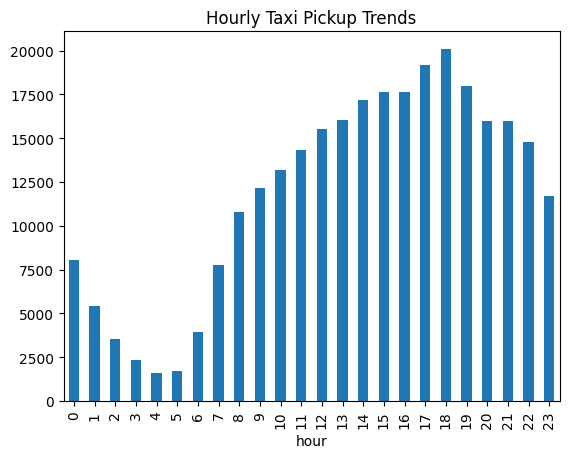

In [98]:
# Find and show the hourly trends in taxi picks 
df1.groupby('hour')['tpep_pickup_datetime'].count().plot(kind='bar', title='Hourly Taxi Pickup Trends')
plt.savefig(r'C:\Users\qaspe\Downloads/hourlytrends.png')
plt.show()

In [ ]:
# Find and show the daily trends in taxi pickups (days of the week)



In [100]:
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
# Need to extract day of the week 
df1['day_of_week'] = df1['tpep_pickup_datetime'].dt.dayofweek
#to get the count of daily_pickups 
daily_pickups = df1.groupby('day_of_week')['tpep_pickup_datetime'].count()
# creating a list of day names 
day_names = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
# Mapping the day _names to the index of daily_pickups 
daily_pickups.index = daily_pickups.index.map(lambda x: day_names[x])

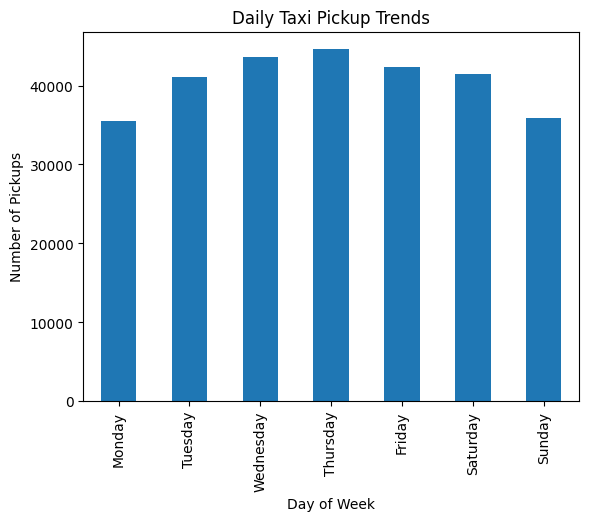

In [104]:
daily_pickups.plot(kind = 'bar' , title = 'Daily Taxi Pickup Trends')
plt.xlabel('Day of Week')
plt.ylabel('Number of Pickups')
plt.savefig(r'C:\Users\qaspe\Downloads/dailytrends.png')
plt.show()

# The daily trends indicate that maximum pickups in Tuesday and then followed by Sunday , Thursday and then Monday. 

In [106]:
df1['tpep_pickup_datetime'].value_counts()

tpep_pickup_datetime
2023-05-24 18:34:20    3
2023-07-14 22:39:59    3
2023-11-30 09:00:12    3
2023-07-26 15:48:12    3
2023-02-14 09:55:16    3
                      ..
2023-12-27 16:14:27    1
2023-12-27 16:31:26    1
2023-12-27 16:02:15    1
2023-12-27 16:49:40    1
2023-09-30 23:23:20    1
Name: count, Length: 282798, dtype: int64

In [ ]:
# Show the monthly trends in pickups



In [108]:
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
# Need to extract day of the week 
df1['month_of_year'] = df1['tpep_pickup_datetime'].dt.month
#to get the count of daily_pickups 
monthly_pickups = df1.groupby('month_of_year')['tpep_pickup_datetime'].count()
# creating a list of day names 
month_names = ['January','February','March','April','May','June','July', 'August','September', 'October' , 'November' , 'December' ]
# Mapping the day _names to the index of daily_pickups 
monthly_pickups.index = monthly_pickups.index.map(lambda x: month_names[x -1])

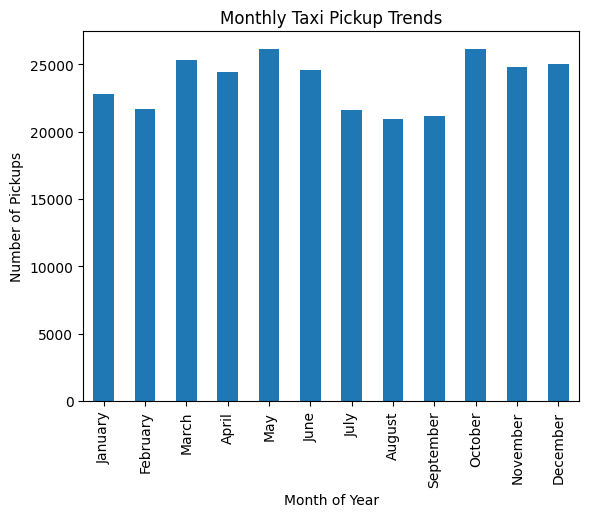

In [110]:
monthly_pickups.plot(kind = 'bar' , title = 'Monthly Taxi Pickup Trends')
plt.xlabel('Month of Year')
plt.ylabel('Number of Pickups')
plt.savefig(r'C:\Users\qaspe\Downloads/monthlytrends.png')
plt.show()

**Higher pickups in the month of May and October as indicated by the graph**

##### Financial Analysis

Take a look at the financial parameters like `fare_amount`, `tip_amount`, `total_amount`, and also `trip_distance`. Do these contain zero/negative values?

In [112]:
# Analyse the above parameters
df1[df1[['fare_amount','tip_amount','total_amount','trip_distance']] < 0]


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0            NaN                  NaT                   NaN              NaN   
1            NaN                  NaT                   NaN              NaN   
2            NaN                  NaT                   NaN              NaN   
3            NaN                  NaT                   NaN              NaN   
4            NaN                  NaT                   NaN              NaN   
...          ...                  ...                   ...              ...   
284487       NaN                  NaT                   NaN              NaN   
284488       NaN                  NaT                   NaN              NaN   
284489       NaN                  NaT                   NaN              NaN   
284490       NaN                  NaT                   NaN              NaN   
284491       NaN                  NaT                   NaN              NaN   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0                 NaN         NaN           NaN           NaN           NaN   
1                 NaN         NaN           NaN           NaN           NaN   
2                 NaN         NaN           NaN           NaN           NaN   
3                 NaN         NaN           NaN           NaN           NaN   
4                 NaN         NaN           NaN           NaN           NaN   
...               ...         ...           ...           ...           ...   
284487            NaN         NaN           NaN           NaN           NaN   
284488            NaN         NaN           NaN           NaN           NaN   
284489            NaN         NaN           NaN           NaN           NaN   
284490            NaN         NaN           NaN           NaN           NaN   
284491            NaN         NaN           NaN           NaN           NaN   

        fare_amount  ...  tip_amount  tolls_amount  improvement_surcharge  \
0               NaN  ...         NaN           NaN                    NaN   
1               NaN  ...         NaN           NaN                    NaN   
2               NaN  ...         NaN           NaN                    NaN   
3               NaN  ...         NaN           NaN                    NaN   
4               NaN  ...         NaN           NaN                    NaN   
...             ...  ...         ...           ...                    ...   
284487          NaN  ...         NaN           NaN                    NaN   
284488          NaN  ...         NaN           NaN                    NaN   
284489          NaN  ...         NaN           NaN                    NaN   
284490          NaN  ...         NaN           NaN                    NaN   
284491          NaN  ...         NaN           NaN                    NaN   

        total_amount  congestion_surcharge  date  hour Airport_fee  \
0                NaN                   NaN   NaN   NaN         NaN   
1                NaN                   NaN   NaN   NaN         NaN   
2                NaN                   NaN   NaN   NaN         NaN   
3                NaN                   NaN   NaN   NaN         NaN   
4                NaN                   NaN   NaN   NaN         NaN   
...              ...                   ...   ...   ...         ...   
284487           NaN                   NaN   NaN   NaN         NaN   
284488           NaN                   NaN   NaN   NaN         NaN   
284489           NaN                   NaN   NaN   NaN         NaN   
284490           NaN                   NaN   NaN   NaN         NaN   
284491           NaN                   NaN   NaN   NaN         NaN   

        day_of_week  month_of_year  
0               NaN            NaN  
1               NaN            NaN  
2               NaN            NaN  
3               NaN            NaN  
4               NaN            NaN  
...             ...            ...  
284487          NaN            NaN  
284488          NaN            NaN  

In [114]:
any_negative = (df1[['fare_amount','tip_amount','total_amount','trip_distance']] < 0).any().any()
print(any_negative)

True


In [116]:
df1[['fare_amount','tip_amount','total_amount','trip_distance']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 284487 entries, 0 to 284491
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   fare_amount    284487 non-null  float64
 1   tip_amount     284487 non-null  float64
 2   total_amount   284487 non-null  float64
 3   trip_distance  284487 non-null  float64
dtypes: float64(4)
memory usage: 10.9 MB


In [118]:
df1[['fare_amount','tip_amount','total_amount','trip_distance']].isnull().sum()

fare_amount      0
tip_amount       0
total_amount     0
trip_distance    0
dtype: int64

In [120]:
df1[df1[['fare_amount','tip_amount','total_amount','trip_distance']] < 0] = 0

Do you think it is beneficial to create a copy DataFrame leaving out the zero values from these?

**3.1.3** <font color = red>[2 marks]</font> <br>
Filter out the zero values from the above columns.

**Note:** The distance might be 0 in cases where pickup and drop is in the same zone. Do you think it is suitable to drop such cases of zero distance?

In [122]:
# Create a df with non zero entries for the selected parameters.
df1[df1[['fare_amount','tip_amount','total_amount','trip_distance']] != 0]


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0            NaN                  NaT                   NaN              NaN   
1            NaN                  NaT                   NaN              NaN   
2            NaN                  NaT                   NaN              NaN   
3            NaN                  NaT                   NaN              NaN   
4            NaN                  NaT                   NaN              NaN   
...          ...                  ...                   ...              ...   
284487       NaN                  NaT                   NaN              NaN   
284488       NaN                  NaT                   NaN              NaN   
284489       NaN                  NaT                   NaN              NaN   
284490       NaN                  NaT                   NaN              NaN   
284491       NaN                  NaT                   NaN              NaN   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
0                7.74         NaN           NaN           NaN           NaN   
1                1.24         NaN           NaN           NaN           NaN   
2                1.44         NaN           NaN           NaN           NaN   
3                0.54         NaN           NaN           NaN           NaN   
4               19.24         NaN           NaN           NaN           NaN   
...               ...         ...           ...           ...           ...   
284487           7.06         NaN           NaN           NaN           NaN   
284488           1.57         NaN           NaN           NaN           NaN   
284489           3.61         NaN           NaN           NaN           NaN   
284490           1.91         NaN           NaN           NaN           NaN   
284491           2.50         NaN           NaN           NaN           NaN   

        fare_amount  ...  tip_amount  tolls_amount  improvement_surcharge  \
0             32.40  ...         NaN           NaN                    NaN   
1              7.90  ...        2.58           NaN                    NaN   
2             11.40  ...         NaN           NaN                    NaN   
3              6.50  ...         NaN           NaN                    NaN   
4             25.64  ...        5.93           NaN                    NaN   
...             ...  ...         ...           ...                    ...   
284487        44.30  ...        2.00           NaN                    NaN   
284488        11.40  ...        3.28           NaN                    NaN   
284489        21.90  ...        5.38           NaN                    NaN   
284490        12.80  ...        3.56           NaN                    NaN   
284491        15.60  ...        2.50           NaN                    NaN   

        total_amount  congestion_surcharge  date  hour Airport_fee  \
0              41.15                   NaN   NaN   NaN         NaN   
1              15.48                   NaN   NaN   NaN         NaN   
2              16.40                   NaN   NaN   NaN         NaN   
3              11.50                   NaN   NaN   NaN         NaN   
4              35.57                   NaN   NaN   NaN         NaN   
...              ...                   ...   ...   ...         ...   
284487         51.30                   NaN   NaN   NaN         NaN   
284488         19.68                   NaN   NaN   NaN         NaN   
284489         32.28                   NaN   NaN   NaN         NaN   
284490         21.36                   NaN   NaN   NaN         NaN   
284491         23.10                   NaN   NaN   NaN         NaN   

        day_of_week  month_of_year  
0               NaN            NaN  
1               NaN            NaN  
2               NaN            NaN  
3               NaN            NaN  
4               NaN            NaN  
...             ...            ...  
284487          NaN            NaN  
284488          NaN            NaN  

In [124]:
df1[df1['trip_distance'] == 0]

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
55             2  2023-01-01 01:34:06   2023-01-01 01:34:14              2.0   
74             1  2023-01-01 01:25:41   2023-01-01 01:25:45              1.0   
80             1  2023-01-01 01:26:38   2023-01-01 01:27:12              1.0   
81             2  2023-01-01 01:20:00   2023-01-01 01:20:02              4.0   
125            2  2023-01-01 03:18:36   2023-01-01 03:18:42              1.0   
...          ...                  ...                   ...              ...   
284405         1  2023-09-30 22:53:15   2023-09-30 23:10:04              1.0   
284424         1  2023-09-30 22:25:15   2023-09-30 22:25:19              1.0   
284451         2  2023-09-30 23:34:29   2023-09-30 23:49:06              1.0   
284466         1  2023-09-30 23:12:36   2023-09-30 23:36:35              1.0   
284483         1  2023-09-30 23:31:35   2023-09-30 23:41:26              1.0   

        trip_distance  RatecodeID  PULocationID  DOLocationID  payment_type  \
55                0.0         5.0           265           265             1   
74                0.0         1.0           148           148             1   
80                0.0         5.0           229           229             1   
81                0.0         5.0           264           264             1   
125               0.0         1.0           113           113             2   
...               ...         ...           ...           ...           ...   
284405            0.0         1.0            48           249             1   
284424            0.0         1.0           152           152             1   
284451            0.0         1.0           264           264             1   
284466            0.0         1.0           161            87             1   
284483            0.0         1.0           249           231             1   

        fare_amount  ...  tip_amount  tolls_amount  improvement_surcharge  \
55            50.00  ...       10.20           0.0                    1.0   
74             3.00  ...       52.00           0.0                    1.0   
80             5.00  ...        0.00           0.0                    1.0   
81            45.00  ...        0.80           0.0                    1.0   
125            3.00  ...        0.00           0.0                    1.0   
...             ...  ...         ...           ...                    ...   
284405        21.88  ...        0.00           0.0                    1.0   
284424        34.50  ...        0.00           0.0                    1.0   
284451        12.80  ...        4.59           0.0                    1.0   
284466        31.01  ...        0.00           0.0                    1.0   
284483        20.65  ...        0.00           0.0                    1.0   

        total_amount  congestion_surcharge        date  hour Airport_fee  \
55             61.20                   0.0  2023-01-01     1         0.0   
74             60.00                   2.5  2023-01-01     1         0.0   
80              6.00                   0.0  2023-01-01     1         0.0   
81             46.80                   0.0  2023-01-01     1         0.0   
125             8.00                   2.5  2023-01-01     3         0.0   
...              ...                   ...         ...   ...         ...   
284405         25.88                   2.5  2023-09-30    22         0.0   
284424         36.00                   0.0  2023-09-30    22         0.0   
284451         19.89                   0.0  2023-09-30    23         0.0   
284466         35.01                   2.5  2023-09-30    23         0.0   
284483         24.65                   2.5  2023-09-30    23         0.0   

        day_of_week  month_of_year  
55                6              1  
74                6              1  
80                6              1  
81                6              1  
125               6              1  
...             ...            ...  
2

In [126]:
any_negative = (df1['fare_amount'] < 0).any().any()
print(any_negative)

False


In [128]:
any_negative = (df1['tip_amount'] < 0).any().any()
print(any_negative)

False


In [130]:
any_negative = (df1['total_amount'] < 0).any().any()
print(any_negative)

False


In [132]:
any_negative = (df1['trip_distance'] < 0).any().any()
print(any_negative)

False


In [ ]:
df1.trip_distance.replace(0,1.8)

**3.1.4** <font color = red>[3 marks]</font> <br>
Analyse the monthly revenue (`total_amount`) trend

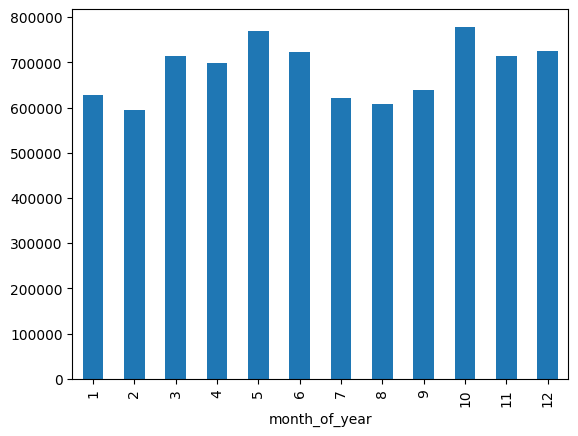

In [136]:
# Group data by month and analyse monthly revenue
df1.groupby('month_of_year')['total_amount'].sum().plot.bar()
plt.savefig(r'C:\Users\qaspe\Downloads/monthlyrevenuetrends.png')
plt.show()


**3.1.5** <font color = red>[3 marks]</font> <br>
Show the proportion of each quarter of the year in the revenue

In [142]:
df1['quarter'] = df1['tpep_pickup_datetime'].dt.quarter

In [144]:
# Calculate proportion of each quarter
revenue_by_quarter = df1.groupby('quarter')['total_amount'].sum().reset_index()
total_revenue = revenue_by_quarter['total_amount'].sum()
revenue_by_quarter['proportions'] = (revenue_by_quarter['total_amount']/total_revenue)*100
print("Revenue Proportion by Quarter:")
print(revenue_by_quarter[['quarter', 'proportions']])

Revenue Proportion by Quarter:
   quarter  proportions
0        1    23.568261
1        2    26.679135
2        3    22.746326
3        4    27.006278


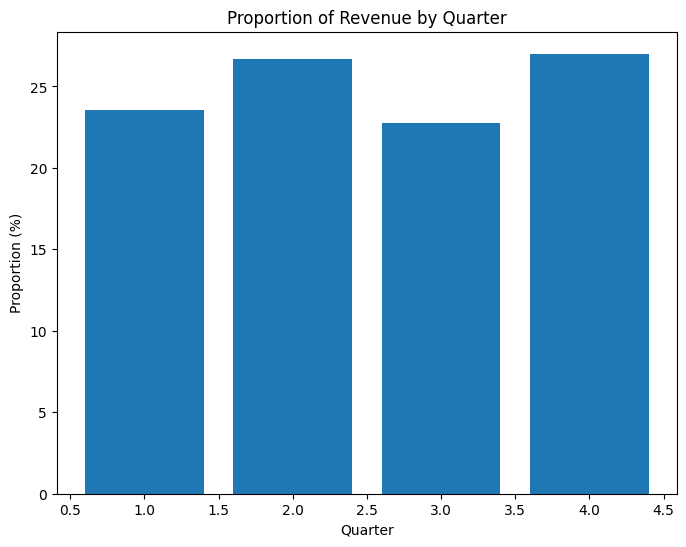

In [146]:
plt.figure(figsize=(8, 6))
plt.bar(revenue_by_quarter['quarter'], revenue_by_quarter['proportions'])
plt.title("Proportion of Revenue by Quarter")
plt.xlabel("Quarter")
plt.ylabel("Proportion (%)")
plt.savefig(r'C:\Users\qaspe\Downloads/quarterrevenuetrends.png')
plt.show()

**indicates a higher revenue in the fourth quarter**

**3.1.6** <font color = red>[3 marks]</font> <br>
Visualise the relationship between `trip_distance` and `fare_amount`. Also find the correlation value for these two.

**Hint:** You can leave out the trips with trip_distance = 0

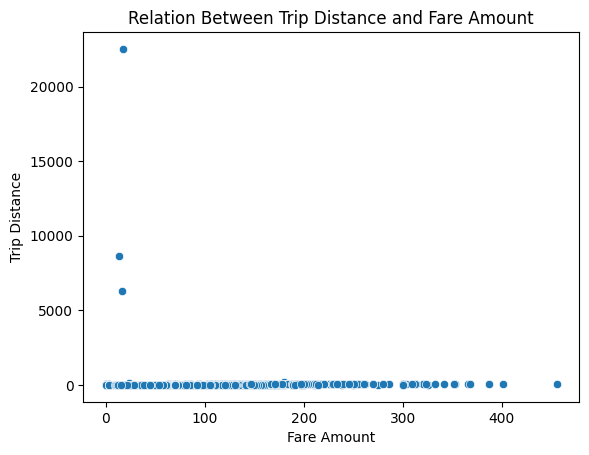

In [148]:
# Show how trip fare is affected by distance

sns.scatterplot(data = df1[df1['trip_distance'] > 0] , x = 'fare_amount' , y = 'trip_distance' )
plt.title('Relation Between Trip Distance and Fare Amount')
plt.xlabel( 'Fare Amount')
plt.ylabel('Trip Distance')
plt.savefig(r'C:\Users\qaspe\Downloads/tripfaredistance.png')
plt.show()

**the graph indicates that the Fare Amount is 300 for a trip distance of 75. Both Fare Amount and Trip Distance indicates a postive correlation for a distance of upto 75 and fare amount of 300**

**3.1.7** <font color = red>[5 marks]</font> <br>
Find and visualise the correlation between:
1. `fare_amount` and trip duration (pickup time to dropoff time)
2. `fare_amount` and `passenger_count`
3. `tip_amount` and `trip_distance`

In [ ]:
# Show relationship between fare and trip duration

In [150]:
df1['tpep_pickup_datetime'] = pd.to_datetime(df1['tpep_pickup_datetime'])
df1['tpep_dropoff_datetime'] = pd.to_datetime(df1['tpep_dropoff_datetime'])
df1['trip_duration'] = (df1['tpep_dropoff_datetime'] - df1['tpep_pickup_datetime']).dt.total_seconds()
df1['trip_duration'] = df1['trip_duration']/60

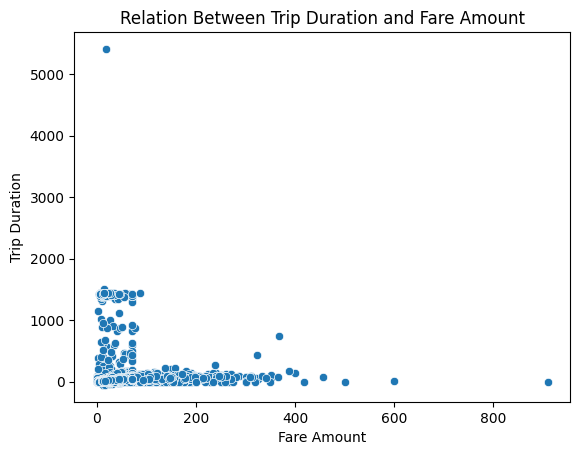

In [152]:
sns.scatterplot(data = df1 , x = 'fare_amount', y = 'trip_duration')
plt.title('Relation Between Trip Duration and Fare Amount')
plt.xlabel( 'Fare Amount')
plt.ylabel('Trip Duration')
plt.savefig(r'C:\Users\qaspe\Downloads/tripfareduration.png')
plt.show()

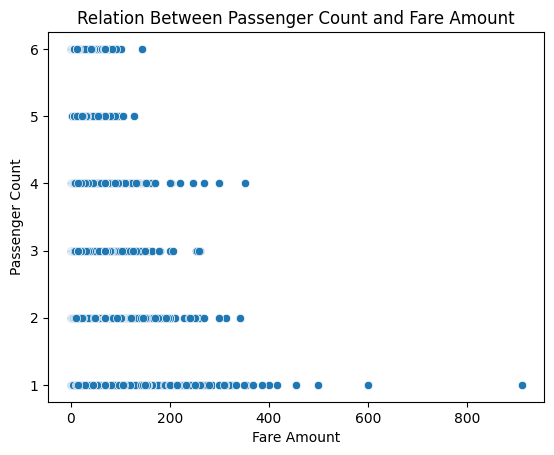

In [154]:
# Show relationship between fare and number of passengers
sns.scatterplot(data = df1 , x = 'fare_amount', y = 'passenger_count')
plt.title('Relation Between Passenger Count and Fare Amount')
plt.xlabel( 'Fare Amount')
plt.ylabel('Passenger Count')
plt.savefig(r'C:\Users\1311r\Downloads/farepassenger.png')
plt.show()


**The maximum fare amount reaches upto 800 when the passenger count is 1. There is also fare amount more than 300 with passenger count of 4**

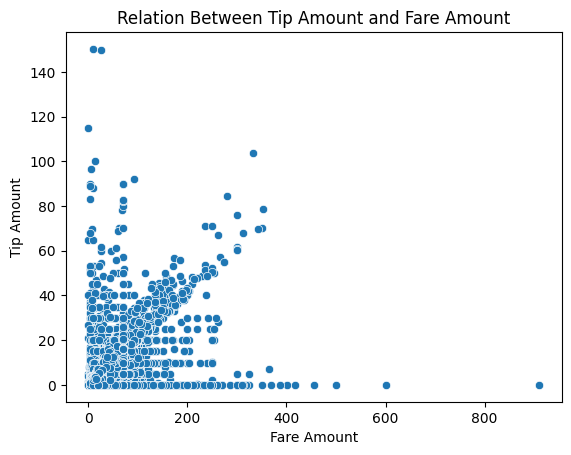

In [156]:
# Show relationship between tip and trip distance
sns.scatterplot(data = df1 , x = 'fare_amount', y = 'tip_amount')
plt.title('Relation Between Tip Amount and Fare Amount')
plt.xlabel( 'Fare Amount')
plt.ylabel('Tip Amount')
plt.savefig(r'C:\Users\qaspe\Downloads/faretip.png')
plt.show()


**Graph indicates a very positive correlation between Tip Amount and Fare Amount. The positive is clearly indicated upto Fare Amount of upto 400 which is corresponding to a Tip Amount of 60. Although interestingly there are two outliers too. A veru high tip amount of 140 for a fare amount less than 200 and also no tip amount for a fare amount more than 800.**

In [158]:
corr_columns = ['fare_amount', 'trip_duration', 'passenger_count', 'tip_amount', 'trip_distance']
correlation_matrix = df1[corr_columns].corr()
print(correlation_matrix)

                 fare_amount  trip_duration  passenger_count  tip_amount  \
fare_amount         1.000000       0.268308         0.041015    0.589673   
trip_duration       0.268308       1.000000         0.021131    0.157152   
passenger_count     0.041015       0.021131         1.000000    0.015622   
tip_amount          0.589673       0.157152         0.015622    1.000000   
trip_distance       0.085650       0.024935         0.002511    0.053753   

                 trip_distance  
fare_amount           0.085650  
trip_duration         0.024935  
passenger_count       0.002511  
tip_amount            0.053753  
trip_distance         1.000000  


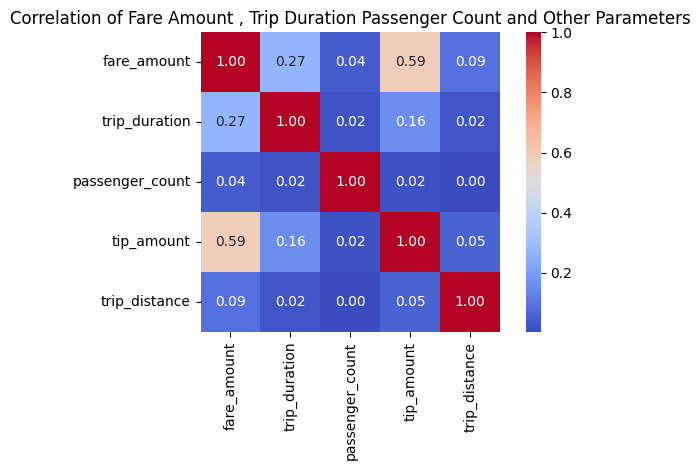

In [160]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title( 'Correlation of Fare Amount , Trip Duration Passenger Count and Other Parameters')
plt.savefig(r'C:\Users\qaspe\Downloads/heatmap.png')
plt.tight_layout()
plt.show()

**Most strongest positive correlation between Trip Distance and Fare amount followed by tip amount and fare amount**

**3.1.8** <font color = red>[3 marks]</font> <br>
Analyse the distribution of different payment types (`payment_type`)

In [162]:
payment_type_counts = df1['payment_type'].value_counts(normalize = True)*100
print(payment_type_counts)

payment_type
1    82.066667
2    16.760344
4     0.717080
3     0.455908
Name: proportion, dtype: float64


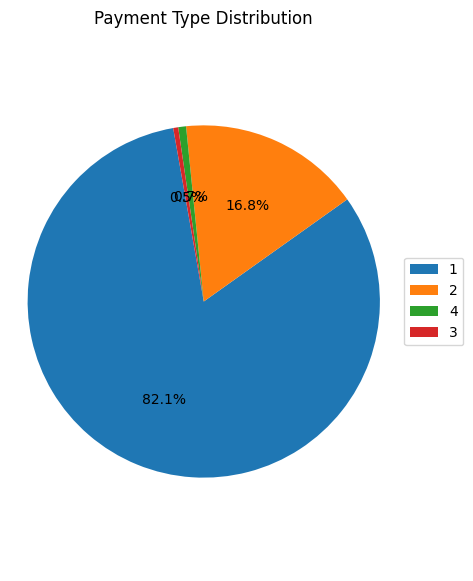

In [164]:
# Analyse the distribution of different payment types (payment_type).
payment_type_counts = df1['payment_type'].value_counts()
plt.figure(figsize = (5,7))
plt.pie(payment_type_counts, autopct='%1.1f%%', startangle=100)
plt.legend(payment_type_counts.index, loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title('Payment Type Distribution')
plt.axis('equal')
plt.savefig(r'C:\Users\1311r\Downloads/paymenttype.png')
plt.show()


**The graphical representation with pie chart indicates a 82% of the payments through credit card and the next significant payment is through cash which is 16.8%. .**

- 1= Credit card
- 2= Cash
- 3= No charge
- 4= Dispute



##### Geographical Analysis

For this, you have to use the *taxi_zones.shp* file from the *taxi_zones* folder.

There would be multiple files inside the folder (such as *.shx, .sbx, .sbn* etc). You do not need to import/read any of the files other than the shapefile, *taxi_zones.shp*.

Do not change any folder structure - all the files need to be present inside the folder for it to work.

The folder structure should look like this:
```
Taxi Zones
|- taxi_zones.shp.xml
|- taxi_zones.prj
|- taxi_zones.sbn
|- taxi_zones.shp
|- taxi_zones.dbf
|- taxi_zones.shx
|- taxi_zones.sbx

 ```

 You only need to read the `taxi_zones.shp` file. The *shp* file will utilise the other files by itself.

We will use the *GeoPandas* library for geopgraphical analysis
```
import geopandas as gpd
```

More about geopandas and shapefiles: [About](https://geopandas.org/en/stable/about.html)


Reading the shapefile is very similar to *Pandas*. Use `gpd.read_file()` function to load the data (*taxi_zones.shp*) as a GeoDataFrame. Documentation: [Reading and Writing Files](https://geopandas.org/en/stable/docs/user_guide/io.html)

In [ ]:
pip install geopandas

**3.1.9** <font color = red>[2 marks]</font> <br>
Load the shapefile and display it.

In [168]:
import geopandas as gpd
zones = gpd.read_file(r"C:\Users\qaspe\Downloads\Datasets and Dictionary-NYC\Datasets and Dictionary\taxi_zones.shp")

In [170]:
zones.head()

OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.77 256767.698, 1026495.593 2...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.31 144283.336, 936046.565 144...

Now, if you look at the DataFrame created, you will see columns like: `OBJECTID`,`Shape_Leng`, `Shape_Area`, `zone`, `LocationID`, `borough`, `geometry`.
<br><br>

Now, the `locationID` here is also what we are using to mark pickup and drop zones in the trip records.

The geometric parameters like shape length, shape area and geometry are used to plot the zones on a map.

This can be easily done using the `plot()` method.

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    263 non-null    int32   
 1   Shape_Leng  263 non-null    float64 
 2   Shape_Area  263 non-null    float64 
 3   zone        263 non-null    object  
 4   LocationID  263 non-null    int32   
 5   borough     263 non-null    object  
 6   geometry    263 non-null    geometry
dtypes: float64(2), geometry(1), int32(2), object(2)
memory usage: 12.5+ KB
None


<Axes: >

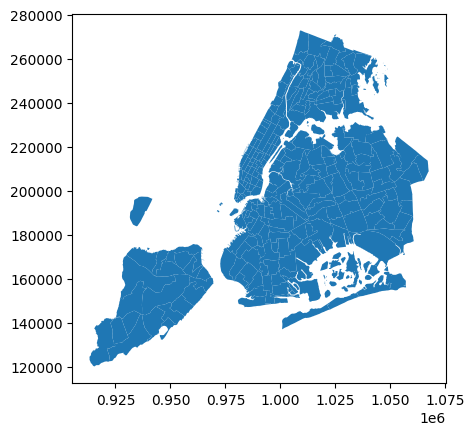

In [172]:
print(zones.info())
zones.plot()

Now, you have to merge the trip records and zones data using the location IDs.



**3.1.10** <font color = red>[3 marks]</font> <br>
Merge the zones data into trip data using the `locationID` and `PULocationID` columns.

In [174]:
# Merge zones and trip records using locationID and PULocationID
df1.rename(columns = {'PULocationID' : 'LocationID'} , inplace = True)


In [176]:
df2 = pd.merge(df1,zones , left_on='LocationID', right_on='LocationID', how = 'outer')

In [178]:
df2.head()

VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0       2.0  2023-01-04 14:49:22   2023-01-04 14:49:42              2.0   
1       2.0  2023-01-11 07:38:18   2023-01-11 07:38:36              1.0   
2       2.0  2023-01-13 16:22:28   2023-01-13 16:22:31              2.0   
3       2.0  2023-01-15 14:43:19   2023-01-15 14:43:31              1.0   
4       2.0  2023-10-08 10:53:27   2023-10-08 10:53:33              4.0   

   trip_distance  RatecodeID  LocationID  DOLocationID  payment_type  \
0            0.0         5.0           1           1.0           1.0   
1            0.0         5.0           1           1.0           2.0   
2            0.0         5.0           1         264.0           1.0   
3            0.0         5.0           1           1.0           4.0   
4            0.0         5.0           1           1.0           1.0   

   fare_amount  ...  day_of_week  month_of_year  quarter  trip_duration  \
0       150.00  ...          2.0            1.0      1.0       0.333333   
1       110.00  ...          2.0            1.0      1.0       0.300000   
2       150.00  ...          4.0            1.0      1.0       0.050000   
3       123.25  ...          6.0            1.0      1.0       0.200000   
4       110.00  ...          6.0           10.0      4.0       0.100000   

   OBJECTID  Shape_Leng  Shape_Area            zone  borough  \
0       1.0    0.116357    0.000782  Newark Airport      EWR   
1       1.0    0.116357    0.000782  Newark Airport      EWR   
2       1.0    0.116357    0.000782  Newark Airport      EWR   
3       1.0    0.116357    0.000782  Newark Airport      EWR   
4       1.0    0.116357    0.000782  Newark Airport      EWR   

                                            geometry  
0  POLYGON ((933100.918 192536.086, 933091.011 19...  
1  POLYGON ((933100.918 192536.086, 933091.011 19...  
2  POLYGON ((933100.918 192536.086, 933091.011 19...  
3  POLYGON ((933100.918 192536.086, 933091.011 19...  
4  POLYGON ((933100.918 192536.086, 933091.011 19...  

[5 rows x 30 columns]

**3.1.11** <font color = red>[3 marks]</font> <br>
Group data by location IDs to find the total number of trips per location ID

In [180]:
# Group data by location and calculate the number of trips
trips_per_location = df2.groupby('LocationID')['LocationID'].count().reset_index(name='total_trips')
print(trips_per_location)

     LocationID  total_trips
0             1           40
1             2            1
2             3           10
3             4          339
4             5            1
..          ...          ...
258         261         1494
259         262         3765
260         263         5466
261         264         2639
262         265          222

[263 rows x 2 columns]


**3.1.12** <font color = red>[2 marks]</font> <br>
Now, use the grouped data to add number of trips to the GeoDataFrame.

We will use this to plot a map of zones showing total trips per zone.

In [182]:
# Merge trip counts back to the zones GeoDataFrame
zones_with_trips = pd.merge(zones, trips_per_location, left_on='LocationID', right_on='LocationID', how='left')



In [184]:
zones_with_trips.sort_values(by = 'total_trips' , ascending = False)

OBJECTID  Shape_Leng  Shape_Area                             zone  \
131       132    0.245479    0.002038                      JFK Airport   
236       237    0.042213    0.000096            Upper East Side South   
160       161    0.035804    0.000072                   Midtown Center   
235       236    0.044252    0.000103            Upper East Side North   
161       162    0.035270    0.000048                     Midtown East   
..        ...         ...         ...                              ...   
153       154    0.227332    0.001790  Marine Park/Floyd Bennett Field   
186       187    0.126868    0.000421                    Port Richmond   
29         30    0.094510    0.000146                    Broad Channel   
7           8    0.027591    0.000027                     Astoria Park   
117       118    0.243966    0.001827      Heartland Village/Todt Hill   

     LocationID        borough  \
131         132         Queens   
236         237      Manhattan   
160         161      Manhattan   
235         236      Manhattan   
161         162      Manhattan   
..          ...            ...   
153         154       Brooklyn   
186         187  Staten Island   
29           30         Queens   
7             8         Queens   
117         118  Staten Island   

                                              geometry  total_trips  
131  MULTIPOLYGON (((1032791.001 181085.006, 103283...        14561  
236  POLYGON ((993633.442 216961.016, 993507.232 21...        13225  
160  POLYGON ((991081.026 214453.698, 990952.644 21...        13125  
235  POLYGON ((995940.048 221122.92, 995812.322 220...        11944  
161  POLYGON ((992224.354 214415.293, 992096.999 21...        10130  
..                                                 ...          ...  
153  MULTIPOLYGON (((1002211.414 161107.153, 100251...            1  
186  MULTIPOLYGON (((946964.115 173161.64, 946977.8...            1  
29   POLYGON ((1034013.272 163473.152, 1034866.459 ...            1  
7    POLYGON ((1005482.276 221686.466, 1005304.898 ...            1  
117  POLYGON ((954167.794 161619.974, 954322.65 161...            1  

[263 rows x 8 columns]

The next step is creating a color map (choropleth map) showing zones by the number of trips taken.

Again, you can use the `zones.plot()` method for this. [Plot Method GPD](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.plot.html#geopandas.GeoDataFrame.plot)

But first, you need to define the figure and axis for the plot.

`fig, ax = plt.subplots(1, 1, figsize = (12, 10))`

This function creates a figure (fig) and a single subplot (ax)

---

After setting up the figure and axis, we can proceed to plot the GeoDataFrame on this axis. This is done in the next step where we use the plot method of the GeoDataFrame.

You can define the following parameters in the `zones.plot()` method:
```
column = '',
ax = ax,
legend = True,
legend_kwds = {'label': "label", 'orientation': "<horizontal/vertical>"}
```

To display the plot, use `plt.show()`.

**3.1.13** <font color = red>[3 marks]</font> <br>
Plot a color-coded map showing zone-wise trips

In [ ]:
# Define figure and axis


# Plot the map and display it



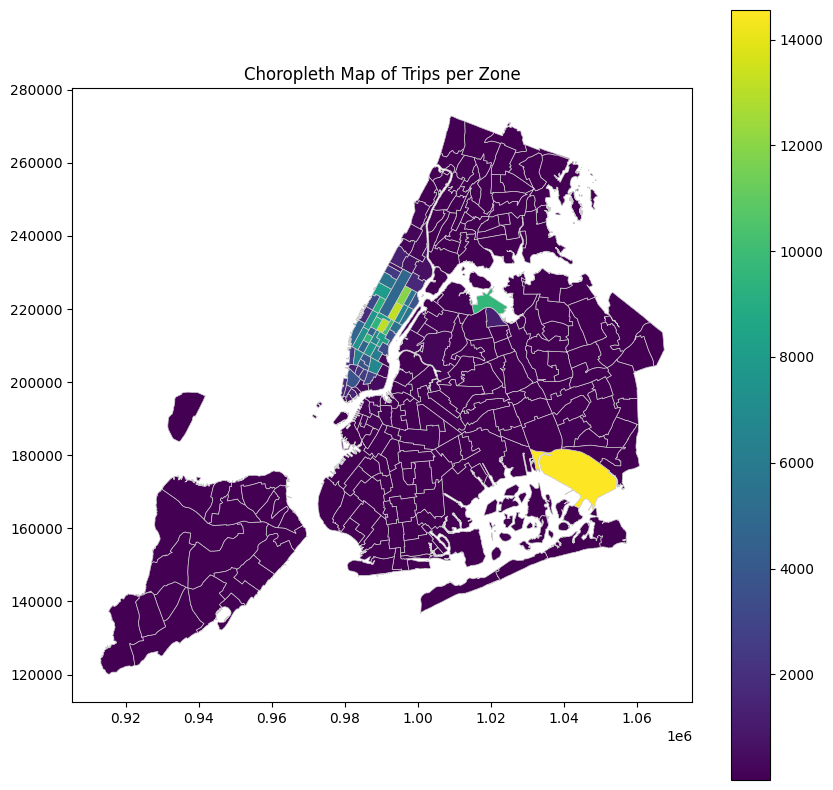

In [186]:
fig , ax = plt.subplots(1,1,figsize = (10,10))
zones_with_trips.plot(column = 'total_trips' , cmap='viridis', linewidth=0.5, ax=ax, edgecolor='0.8', legend=True)
ax.set_title('Choropleth Map of Trips per Zone')
plt.savefig(r'C:\Users\1311r\Downloads/choroplethmap.png')
plt.show()

In [188]:
# can you try displaying the zones DF sorted by the number of trips?

zones_with_trips.sort_values(by = ['total_trips'] , ascending = False)

OBJECTID  Shape_Leng  Shape_Area                             zone  \
131       132    0.245479    0.002038                      JFK Airport   
236       237    0.042213    0.000096            Upper East Side South   
160       161    0.035804    0.000072                   Midtown Center   
235       236    0.044252    0.000103            Upper East Side North   
161       162    0.035270    0.000048                     Midtown East   
..        ...         ...         ...                              ...   
153       154    0.227332    0.001790  Marine Park/Floyd Bennett Field   
186       187    0.126868    0.000421                    Port Richmond   
29         30    0.094510    0.000146                    Broad Channel   
7           8    0.027591    0.000027                     Astoria Park   
117       118    0.243966    0.001827      Heartland Village/Todt Hill   

     LocationID        borough  \
131         132         Queens   
236         237      Manhattan   
160         161      Manhattan   
235         236      Manhattan   
161         162      Manhattan   
..          ...            ...   
153         154       Brooklyn   
186         187  Staten Island   
29           30         Queens   
7             8         Queens   
117         118  Staten Island   

                                              geometry  total_trips  
131  MULTIPOLYGON (((1032791.001 181085.006, 103283...        14561  
236  POLYGON ((993633.442 216961.016, 993507.232 21...        13225  
160  POLYGON ((991081.026 214453.698, 990952.644 21...        13125  
235  POLYGON ((995940.048 221122.92, 995812.322 220...        11944  
161  POLYGON ((992224.354 214415.293, 992096.999 21...        10130  
..                                                 ...          ...  
153  MULTIPOLYGON (((1002211.414 161107.153, 100251...            1  
186  MULTIPOLYGON (((946964.115 173161.64, 946977.8...            1  
29   POLYGON ((1034013.272 163473.152, 1034866.459 ...            1  
7    POLYGON ((1005482.276 221686.466, 1005304.898 ...            1  
117  POLYGON ((954167.794 161619.974, 954322.65 161...            1  

[263 rows x 8 columns]

Here we have completed the temporal, financial and geographical analysis on the trip records.

**Compile your findings from general analysis below:**

You can consider the following points:

* Busiest hours, days and months
* Trends in revenue collected
* Trends in quarterly revenue
* How fare depends on trip distance, trip duration and passenger counts
* How tip amount depends on trip distance
* Busiest zones


#### **3.2** Detailed EDA: Insights and Strategies
<font color = red>[50 marks]</font> <br>

Having performed basic analyses for finding trends and patterns, we will now move on to some detailed analysis focussed on operational efficiency, pricing strategies, and customer experience.

##### Operational Efficiency

Analyze variations by time of day and location to identify bottlenecks or inefficiencies in routes

**3.2.1** <font color = red>[3 marks]</font> <br>
Identify slow routes by calculating the average time taken by cabs to get from one zone to another at different hours of the day.

Speed on a route *X* for hour *Y* = (*distance of the route X / average trip duration for hour Y*)

In [190]:
df2 = df2[(df2['trip_duration'] > 0) & (df2['trip_distance'] > 0)]
df2 = df2[(df2['trip_duration'] > 0) & (df2['trip_duration'] < 10800)]  # 10800 seconds = 3 hours
df2['speed'] = df2['trip_distance'] / (df2['trip_duration'] / 3600)
route_speeds = df2.groupby(['LocationID', 'DOLocationID', 'hour'])['speed'].mean().reset_index()
slowest_routes_per_hour = route_speeds.loc[route_speeds.groupby('hour')['speed'].idxmin()]
print(slowest_routes_per_hour)

       LocationID  DOLocationID  hour       speed
12613          88         144.0   0.0    4.495370
29797         142         142.0   1.0   45.473684
12888          89          89.0   2.0   18.181818
33429         148         238.0   3.0   15.205772
48227         230          51.0   4.0   43.067952
49136         230         230.0   5.0   21.904225
43013         185         168.0   6.0   49.503438
19984         128         128.0   7.0    6.923077
5574           50          43.0   8.0    3.571495
30215         142         232.0   9.0   17.114921
63688         264         230.0  10.0   56.507521
46309         220         236.0  11.0    5.812702
9931           75         254.0  12.0   51.326733
45151         209         232.0  13.0    2.614738
38334         163          42.0  14.0   36.957479
23510         134         265.0  15.0    4.429861
4731           48         145.0  16.0   10.150847
60754         260         129.0  17.0    2.444764
53253         234         256.0  18.0    8.133310


How does identifying high-traffic, high-demand routes help us?

**3.2.2** <font color = red>[3 marks]</font> <br>
Calculate the number of trips at each hour of the day and visualise them. Find the busiest hour and show the number of trips for that hour.

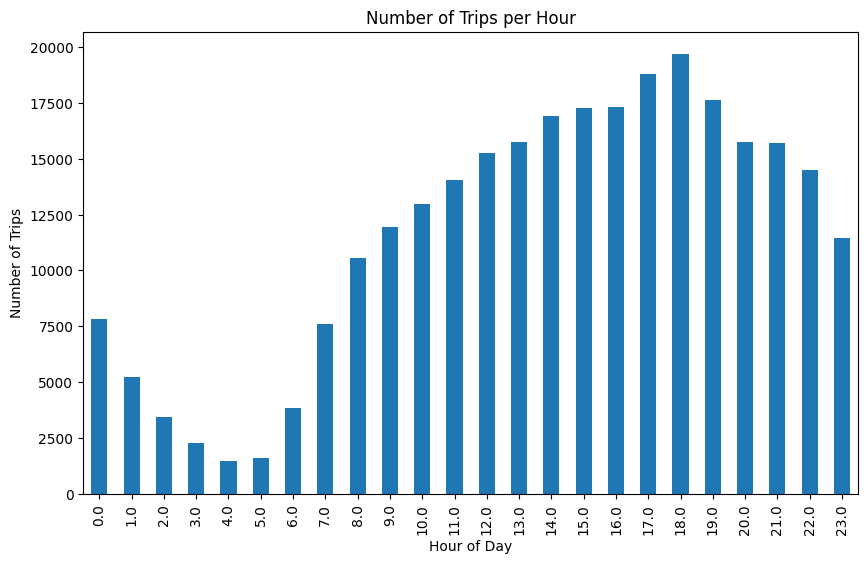

In [196]:
# Visualise the number of trips per hour and find the busiest hour
trips_per_hour = df2.groupby('hour').size()
df2['trips_per_hour'] = df2.groupby('hour')['hour'].count()
trips_per_hour.plot(kind = 'bar', figsize = (10,6))
plt.title('Number of Trips per Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.savefig(r'C:\Users\qaspe\Downloads/houranalysis.png')
plt.show()


In [198]:
busiest_hour =  trips_per_hour.idxmax()
print(f"The busiest hour is : {busiest_hour}")

The busiest hour is : 18.0


Remember, we took a fraction of trips. To find the actual number, you have to scale the number up by the sampling ratio.

**3.2.3** <font color = red>[2 mark]</font> <br>
Find the actual number of trips in the five busiest hours

In [200]:
# Scale up the number of trips

# Fill in the value of your sampling fraction and use that to scale up the numbers
sample_fraction = 0.0075 
df2['scaled_up_trips'] = df2['trips_per_hour']/sample_fraction
# finding the trip counts per hour 
hourly_trip_counts = df2.groupby('hour')['scaled_up_trips'].sum()
busiest_hours = hourly_trip_counts.nlargest(5)
print("Five Busiest Hours:" , busiest_hours)



Five Busiest Hours: hour
13.0    2.506133e+06
11.0    2.307067e+06
16.0    2.253200e+06
20.0    1.527200e+06
0.0     0.000000e+00
Name: scaled_up_trips, dtype: float64


**3.2.4** <font color = red>[3 marks]</font> <br>
Compare hourly traffic pattern on weekdays. Also compare for weekend.

In [202]:
df2.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'LocationID',
       'DOLocationID', 'payment_type', 'fare_amount', 'extra', 'mta_tax',
       'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount',
       'congestion_surcharge', 'date', 'hour', 'Airport_fee', 'day_of_week',
       'month_of_year', 'quarter', 'trip_duration', 'OBJECTID', 'Shape_Leng',
       'Shape_Area', 'zone', 'borough', 'geometry', 'speed', 'trips_per_hour',
       'scaled_up_trips'],
      dtype='object')

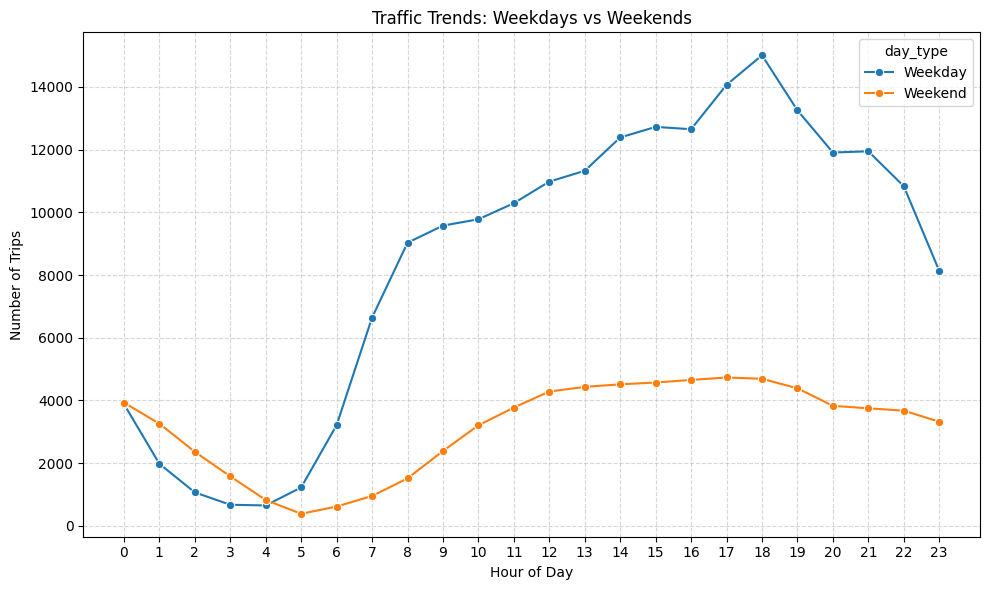

In [206]:
# Compare traffic trends for the week days and weekends
#classifiying days as weekdays and weekends



df2['pickup_hour'] = df2['tpep_pickup_datetime'].dt.hour
df2['day_type'] = df2['day_of_week'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')
# calculating the pickup hours for calculating the trip count
traffic_trends = df2.groupby(['pickup_hour', 'day_type']).size().reset_index(name='trip_count')
# Plotting the trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=traffic_trends, x='pickup_hour', y='trip_count', hue='day_type', marker='o')
plt.title('Traffic Trends: Weekdays vs Weekends')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Trips')
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(r'C:\Users\qaspe\Downloads/daytraffic.png')
plt.show()


What can you infer from the above patterns? How will finding busy and quiet hours for each day help us?

In [208]:
df2['trips_per_hour'] = pd.to_numeric(df2['trips_per_hour'], errors='coerce')
hours_daily_counts = df2.groupby(['date','hour'])['trips_per_hour'].sum()
threshold = 10
busy_hours = hours_daily_counts[hours_daily_counts > threshold].groupby('date').idxmax()
quiet_hours = hours_daily_counts[hours_daily_counts <= threshold].groupby('date').idxmin()
print("Busiest Hours for Each Day:")
print(busy_hours)

print("\nQuietest Hours for Each Day:")
print(quiet_hours)

Busiest Hours for Each Day:
date
2023-02-18    (2023-02-18, 20.0)
2023-03-11    (2023-03-11, 16.0)
2023-06-11    (2023-06-11, 11.0)
2023-08-01    (2023-08-01, 13.0)
Name: trips_per_hour, dtype: object

Quietest Hours for Each Day:
date
2023-01-01    (2023-01-01, 0.0)
2023-01-02    (2023-01-02, 0.0)
2023-01-03    (2023-01-03, 0.0)
2023-01-04    (2023-01-04, 0.0)
2023-01-05    (2023-01-05, 0.0)
                    ...        
2023-12-27    (2023-12-27, 0.0)
2023-12-28    (2023-12-28, 0.0)
2023-12-29    (2023-12-29, 0.0)
2023-12-30    (2023-12-30, 0.0)
2023-12-31    (2023-12-31, 0.0)
Name: trips_per_hour, Length: 365, dtype: object


**3.2.5** <font color = red>[3 marks]</font> <br>
Identify top 10 zones with high hourly pickups. Do the same for hourly dropoffs. Show pickup and dropoff trends in these zones.

In [ ]:
# Find top 10 pickup and dropoff zones

In [210]:
zone_mapping = df2.groupby('LocationID')['zone'].first().to_dict()
df2['pick_up_zone'] = df2['LocationID'].map(zone_mapping)

In [216]:
pick_up_zone_hourly_counts = df2.groupby(['pickup_hour', 'pick_up_zone']).size().reset_index(name='count')

top_10_pickup_zones_by_hour = pick_up_zone_hourly_counts.groupby('pickup_hour').apply(lambda x: x.nlargest(10, 'count')).reset_index(drop=True)

print(top_10_pickup_zones_by_hour)

     pickup_hour                  pick_up_zone  count
0              0                   JFK Airport    599
1              0                  East Village    552
2              0                  West Village    512
3              0       Greenwich Village South    349
4              0     Times Sq/Theatre District    322
..           ...                           ...    ...
235           23     Times Sq/Theatre District    463
236           23                  Clinton East    452
237           23                Midtown Center    439
238           23  Penn Station/Madison Sq West    413
239           23                 Midtown South    345

[240 rows x 3 columns]


In [218]:
zone_mapping = df2.groupby('DOLocationID')['zone'].first().to_dict()
df2['drop_off_zone'] = df2['DOLocationID'].map(zone_mapping)

In [220]:
drop_off_zone_counts = df2['drop_off_zone'].value_counts()
top_10_drop_off_zones = drop_off_zone_counts.nlargest(10)
print("Top 10 Drop-off Zones:")
print(top_10_drop_off_zones)

Top 10 Drop-off Zones:
drop_off_zone
Alphabet City              245565
Allerton/Pelham Gardens     12033
Astoria                      5189
Baisley Park                 3178
Battery Park City            2550
Battery Park                 2484
Newark Airport               1895
Bedford Park                 1024
Bedford                       573
Bay Ridge                     424
Name: count, dtype: int64


**3.2.6** <font color = red>[3 marks]</font> <br>
Find the ratio of pickups and dropoffs in each zone. Display the 10 highest (pickup/drop) and 10 lowest (pickup/drop) ratios.

In [222]:
# Find the top 10 and bottom 10 pickup/dropoff ratios
pickup_counts = df2['pick_up_zone'].value_counts()
drop_off_counts = df2['drop_off_zone'].value_counts()
zone_ratios = pickup_counts.div(drop_off_counts).replace([np.inf, -np.inf], np.nan)
highest_ratios = zone_ratios.nlargest(10, keep='all')
lowest_ratios = zone_ratios[zone_ratios != 0].nsmallest(10, keep='all') 

print("10 Highest Pickup/Dropoff Ratios:")
print(highest_ratios)

print("\n10 Lowest Pickup/Dropoff Ratios:")
print(lowest_ratios)

10 Highest Pickup/Dropoff Ratios:
Greenwich Village South     917.000000
Financial District South    751.000000
JFK Airport                 408.057143
East Harlem South           116.785714
East Chelsea                 35.167464
Central Park                 23.477612
Clinton East                 22.106509
Financial District North     21.194030
Clinton West                 15.336207
East Elmhurst                11.327273
Name: count, dtype: float64

10 Lowest Pickup/Dropoff Ratios:
Allerton/Pelham Gardens    0.000665
Alphabet City              0.001283
Newark Airport             0.002639
Bedford Park               0.006836
Baisley Park               0.024858
Astoria                    0.025631
Auburndale                 0.031915
Bay Ridge                  0.035377
Belmont                    0.037037
Bellerose                  0.038462
Name: count, dtype: float64


**3.2.7** <font color = red>[3 marks]</font> <br>
Identify zones with high pickup and dropoff traffic during night hours (11PM to 5AM)

In [224]:
# During night hours (11pm to 5am) find the top 10 pickup and dropoff zones
# Note that the top zones should be of night hours and not the overall top zones
night_hours_data = df2[(df2['hour'] >= 23) | (df2['hour'] <= 5)]
night_pickup_counts = night_hours_data['pick_up_zone'].value_counts()
night_dropoff_counts = night_hours_data['drop_off_zone'].value_counts()
top_pickup_zones = night_pickup_counts.nlargest(10)
top_dropoff_zones = night_dropoff_counts.nlargest(10)
print("Top 10 Pickup Zones during Night Hours:")
print(top_pickup_zones)

print("\nTop 10 Dropoff Zones during Night Hours:")
print(top_dropoff_zones)

Top 10 Pickup Zones during Night Hours:
pick_up_zone
East Village                    2415
JFK Airport                     2167
West Village                    1959
Clinton East                    1565
Lower East Side                 1506
Greenwich Village South         1306
Times Sq/Theatre District       1300
Penn Station/Madison Sq West    1058
LaGuardia Airport                936
Midtown South                    931
Name: count, dtype: int64

Top 10 Dropoff Zones during Night Hours:
drop_off_zone
Alphabet City              27637
Astoria                     1358
Allerton/Pelham Gardens     1242
Battery Park City            585
Baisley Park                 540
Battery Park                 447
Newark Airport               299
Bedford Park                 198
Bedford                      133
Bay Ridge                    130
Name: count, dtype: int64


Now, let us find the revenue share for the night time hours and the day time hours. After this, we will move to deciding a pricing strategy.

**3.2.8** <font color = red>[2 marks]</font> <br>
Find the revenue share for nighttime and daytime hours.

In [226]:
# Filter for night hours (11 PM to 5 AM)
nighttime_hours = [23, 0, 1, 2, 3, 4, 5]
daytime_hours = list(range(6,23))
nighttime_data = df2[df2['hour'].isin(nighttime_hours)]
daytime_data = df2[df2['hour'].isin(daytime_hours)]
nighttime_revenue = nighttime_data['total_amount'].sum()
daytime_revenue = daytime_data['total_amount'].sum()
total_revenue = nighttime_revenue + daytime_revenue
nighttime_share = (nighttime_revenue / total_revenue) * 100
daytime_share = (daytime_revenue / total_revenue) * 100
print("Revenue Share:")
print(f"Nighttime: {nighttime_share:.2f}%")
print(f"Daytime: {daytime_share:.2f}%")


Revenue Share:
Nighttime: 12.24%
Daytime: 87.76%


##### Pricing Strategy

**3.2.9** <font color = red>[2 marks]</font> <br>
For the different passenger counts, find the average fare per mile per passenger.

For instance, suppose the average fare per mile for trips with 3 passengers is 3 USD/mile, then the fare per mile per passenger will be 1 USD/mile.

In [228]:
# Analyse the fare per mile per passenger for different passenger counts
filtered_df2 = df2[(df2['trip_distance'] > 0) & (df2['passenger_count'] > 0)].copy()
filtered_df2['fare_per_mile'] = filtered_df2['fare_amount']/filtered_df2['trip_distance']
filtered_df2['fare_per_mile_per_passenger'] = filtered_df2['fare_per_mile']/ filtered_df2['passenger_count']
average_fare_per_mile_per_passenger = filtered_df2.groupby('passenger_count')['fare_per_mile_per_passenger'].mean()
print('Average Fare Per Mile Per Passenger:')
print(average_fare_per_mile_per_passenger)

Average Fare Per Mile Per Passenger:
passenger_count
1.0    10.671570
2.0     6.309322
3.0     4.287352
4.0     4.977417
5.0     1.582083
6.0     1.283236
Name: fare_per_mile_per_passenger, dtype: float64


**3.2.10** <font color = red>[3 marks]</font> <br>
Find the average fare per mile by hours of the day and by days of the week

In [230]:
# Compare the average fare per mile for different days and for different times of the day
average_fare_per_mile_per_hour = filtered_df2.groupby('hour')['fare_per_mile'].mean()
average_fare_per_mile_per_day = filtered_df2.groupby('day_of_week')['fare_per_mile'].mean()
print('Average Fare Per Mile Per Hour:' )
print(average_fare_per_mile_per_hour)
print('Average Fare Per Mile Per Day:')
print(average_fare_per_mile_per_day)


Average Fare Per Mile Per Hour:
hour
0.0     11.771444
1.0     14.878920
2.0      8.870534
3.0      9.997160
4.0     18.239001
5.0     11.517208
6.0     12.186599
7.0      8.552603
8.0      9.756161
9.0      9.959959
10.0    10.393994
11.0    10.953026
12.0    11.542447
13.0    12.437976
14.0    12.201411
15.0    11.185239
16.0    13.909275
17.0    11.947539
18.0    10.214458
19.0    11.640265
20.0     9.509119
21.0     9.288332
22.0    11.849068
23.0     9.682907
Name: fare_per_mile, dtype: float64
Average Fare Per Mile Per Day:
day_of_week
0.0    10.234977
1.0    11.157818
2.0    11.366173
3.0    12.429725
4.0     9.810470
5.0    11.215025
6.0    11.797917
Name: fare_per_mile, dtype: float64


**3.2.11** <font color = red>[3 marks]</font> <br>
Analyse the average fare per mile for the different vendors for different hours of the day

In [232]:
# Compare fare per mile for different vendo
average_fare_per_mile_per_hour_per_vendor = filtered_df2.groupby(['VendorID', 'hour'])['fare_per_mile'].mean().reset_index()
print("Average Fare per Mile by Vendor and Hour of the Day:")
print(average_fare_per_mile_per_hour_per_vendor)

Average Fare per Mile by Vendor and Hour of the Day:
    VendorID  hour  fare_per_mile
0        1.0   0.0       6.593734
1        1.0   1.0       7.155493
2        1.0   2.0       7.085528
3        1.0   3.0       6.410625
4        1.0   4.0       6.062375
..       ...   ...            ...
60       6.0  17.0       3.905159
61       6.0  18.0       5.819828
62       6.0  20.0       4.114431
63       6.0  21.0       3.608295
64       6.0  23.0       3.210944

[65 rows x 3 columns]


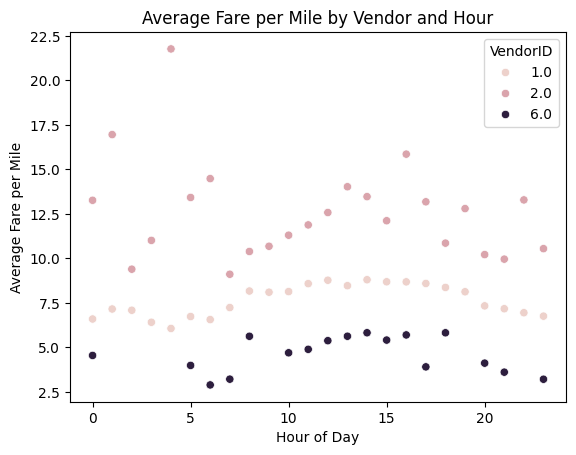

In [234]:
sns.scatterplot(data=average_fare_per_mile_per_hour_per_vendor, x="hour", y="fare_per_mile", hue="VendorID")
plt.title("Average Fare per Mile by Vendor and Hour")
plt.xlabel("Hour of Day")
plt.ylabel("Average Fare per Mile")
plt.savefig(r'C:\Users\qaspe\Downloads/farevendor.png')
plt.show()

**3.2.12** <font color = red>[5 marks]</font> <br>
Compare the fare rates of the different vendors in a tiered fashion. Analyse the average fare per mile for distances upto 2 miles. Analyse the fare per mile for distances from 2 to 5 miles. And then for distances more than 5 miles.


Average Fare per mile per vendor per distance category:
   VendorID     distance_tiers  fare_per_mile
0       1.0       upto 2 miles       9.757801
1       1.0       2 to 5 miles       6.380492
2       1.0  more than 5 miles       4.409115
3       2.0       upto 2 miles      17.868698
4       2.0       2 to 5 miles       6.531478
5       2.0  more than 5 miles       4.487829
6       6.0       upto 2 miles            NaN
7       6.0       2 to 5 miles       7.641845
8       6.0  more than 5 miles       4.118863


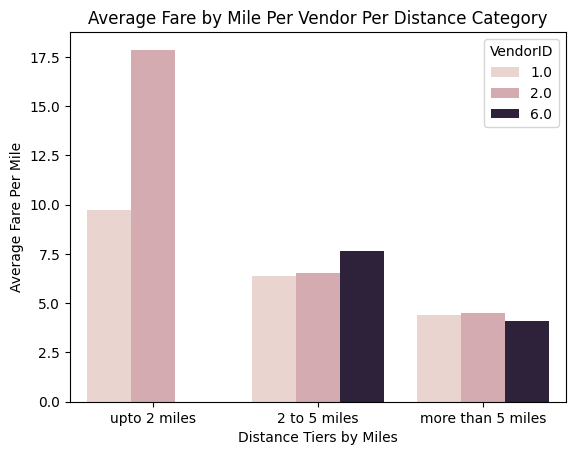

In [236]:
# Defining distance tiers
# creating distance tiers first
filtered_df2['distance_tiers'] = pd.cut(filtered_df2['trip_distance'] , bins = [0, 2, 5, float('inf')] , labels = ['upto 2 miles' ,'2 to 5 miles','more than 5 miles']) 
average_fare_by_vendor_tiers = filtered_df2.groupby(['VendorID', 'distance_tiers'], observed = False)['fare_per_mile'].mean().reset_index()
print('Average Fare per mile per vendor per distance category:')
print(average_fare_by_vendor_tiers)
sns.barplot(data = average_fare_by_vendor_tiers , x = 'distance_tiers' , y = 'fare_per_mile' , hue = 'VendorID')
plt.title('Average Fare by Mile Per Vendor Per Distance Category')
plt.xlabel('Distance Tiers by Miles')
plt.ylabel('Average Fare Per Mile')
plt.savefig(r'C:\Users\qaspe\Downloads/farevendorbins.png')
plt.show()

##### Customer Experience and Other Factors

**3.2.13** <font color = red>[5 marks]</font> <br>
Analyse average tip percentages based on trip distances, passenger counts and time of pickup. What factors lead to low tip percentages?

In [238]:
#  Analyze tip percentages based on distances, passenger counts and pickup times
#calcutating tip percentage 
filtered_df2['tip_percentage'] = filtered_df2['tip_amount'] / filtered_df2['total_amount']*100
average_tip_percentage = filtered_df2.groupby(['trip_distance' , 'passenger_count' , 'tpep_pickup_datetime'])['tip_percentage'].mean().reset_index()
print("Average Tip Percentage by Distance, Passenger Count, and Pickup Time")
print(average_tip_percentage)


Average Tip Percentage by Distance, Passenger Count, and Pickup Time
        trip_distance  passenger_count tpep_pickup_datetime  tip_percentage
0                0.01              1.0  2023-01-01 13:19:39        0.000000
1                0.01              1.0  2023-01-04 16:03:39        0.000000
2                0.01              1.0  2023-01-10 00:22:19        0.000000
3                0.01              1.0  2023-01-11 17:29:14        0.000000
4                0.01              1.0  2023-01-14 19:25:29        0.000000
...               ...              ...                  ...             ...
278821         104.30              1.0  2023-08-25 14:29:44        9.090909
278822         187.35              1.0  2023-12-18 10:52:49        0.077359
278823        6284.45              1.0  2023-02-19 22:06:00        0.000000
278824        8645.77              1.0  2023-02-17 07:17:00       20.018450
278825       22528.82              1.0  2023-06-13 09:59:00        1.698027

[278826 rows x 4 c

In [240]:
filtered_df2['tip_percentage'] = filtered_df2['tip_amount'] / filtered_df2['total_amount']*100
average_tip_percentage_hour = filtered_df2.groupby(['trip_distance' , 'passenger_count' , 'hour'])['tip_percentage'].mean().reset_index()
print("Average Tip Percentage by Distance, Passenger Count, and Hour")
print(average_tip_percentage_hour)

Average Tip Percentage by Distance, Passenger Count, and Hour
       trip_distance  passenger_count  hour  tip_percentage
0               0.01              1.0   0.0        3.337912
1               0.01              1.0   1.0        5.555556
2               0.01              1.0   2.0       11.538462
3               0.01              1.0   3.0       11.109003
4               0.01              1.0   4.0       11.111111
...              ...              ...   ...             ...
60262         104.30              1.0  14.0        9.090909
60263         187.35              1.0  10.0        0.077359
60264        6284.45              1.0  22.0        0.000000
60265        8645.77              1.0   7.0       20.018450
60266       22528.82              1.0   9.0        1.698027

[60267 rows x 4 columns]


Additional analysis [optional]: Let's try comparing cases of low tips with cases of high tips to find out if we find a clear aspect that drives up the tipping behaviours

In [242]:
# Compare trips with tip percentage < 10% to trips with tip percentage > 25%
filtered_df2[filtered_df2['tip_percentage'] < 10].groupby('tip_percentage')['trips_per_hour'].count()


tip_percentage
0.000000    1
0.008829    0
0.009523    0
0.010250    0
0.011403    0
           ..
9.982032    0
9.983361    0
9.990010    0
9.990999    0
9.993338    0
Name: trips_per_hour, Length: 4597, dtype: int64

In [244]:
filtered_df2[filtered_df2['tip_percentage'] > 25].groupby('tip_percentage')['trips_per_hour'].count()

tip_percentage
25.047801    0
25.092251    0
25.104603    0
25.125628    0
25.125628    0
            ..
92.222222    0
92.708333    0
95.454545    0
96.428571    0
98.484848    0
Name: trips_per_hour, Length: 593, dtype: int64

**3.2.14** <font color = red>[3 marks]</font> <br>
Analyse the variation of passenger count across hours and days of the week.

In [246]:
# See how passenger count varies across hours and days
average_passenger_per_day_per_hour = filtered_df2.groupby(['hour','day_of_week'])['passenger_count'].mean().reset_index()





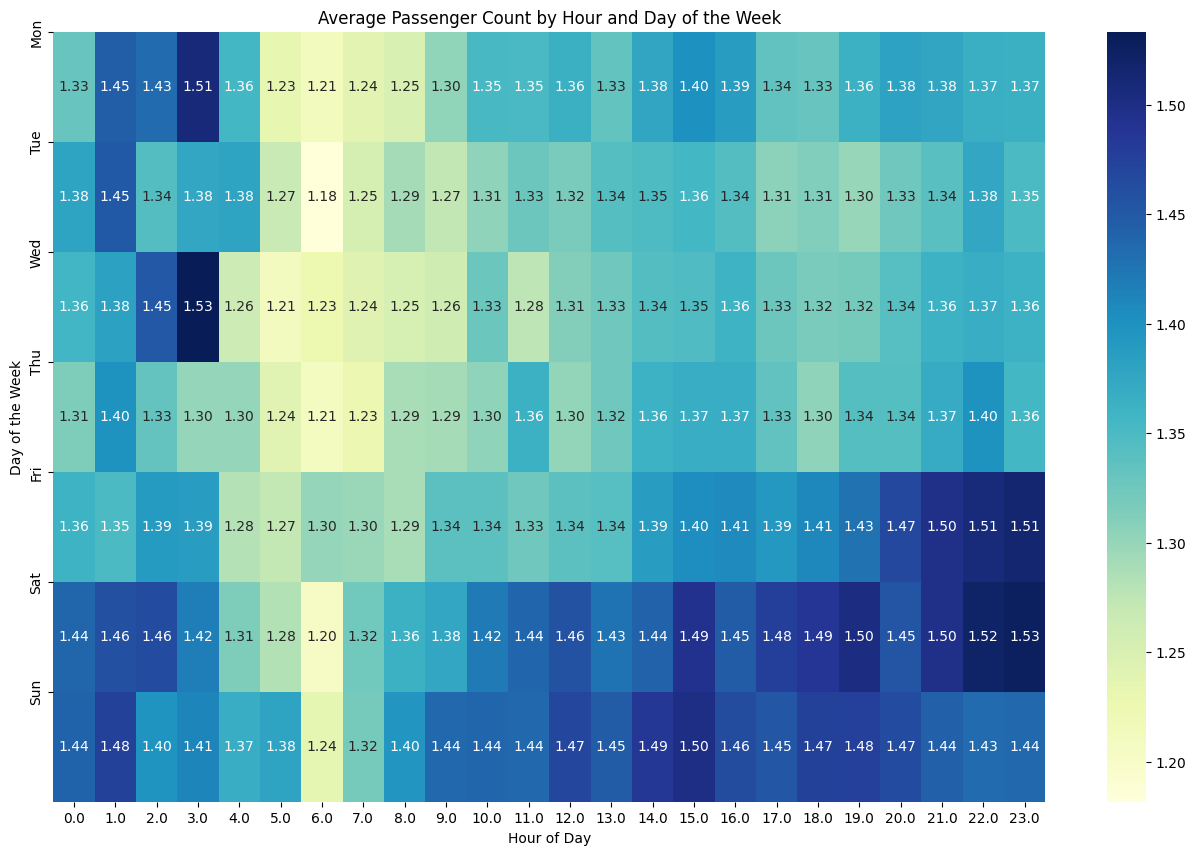

In [248]:
heatmap_data = average_passenger_per_day_per_hour.pivot_table(index="day_of_week", columns="hour", values="passenger_count")
plt.figure(figsize=(16, 10))
sns.heatmap(heatmap_data, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title("Average Passenger Count by Hour and Day of the Week")
plt.xlabel("Hour of Day")
plt.ylabel("Day of the Week")
plt.yticks(ticks=range(0, 7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])  # Set y-axis labels
plt.savefig(r'C:\Users\qaspe\Downloads/passengercount.png')
plt.show()

**3.2.15** <font color = red>[2 marks]</font> <br>
Analyse the variation of passenger counts across zones

In [250]:
# How does passenger count vary across zones
passenger_count_per_zone = filtered_df2.groupby('zone')['passenger_count'].count().reset_index()
print(passenger_count_per_zone)

                        zone  passenger_count
0    Allerton/Pelham Gardens                8
1              Alphabet City              315
2              Arden Heights                1
3    Arrochar/Fort Wadsworth                3
4                    Astoria              133
..                       ...              ...
231       Woodlawn/Wakefield                4
232                 Woodside               43
233       World Trade Center             1473
234           Yorkville East             3687
235           Yorkville West             5385

[236 rows x 2 columns]


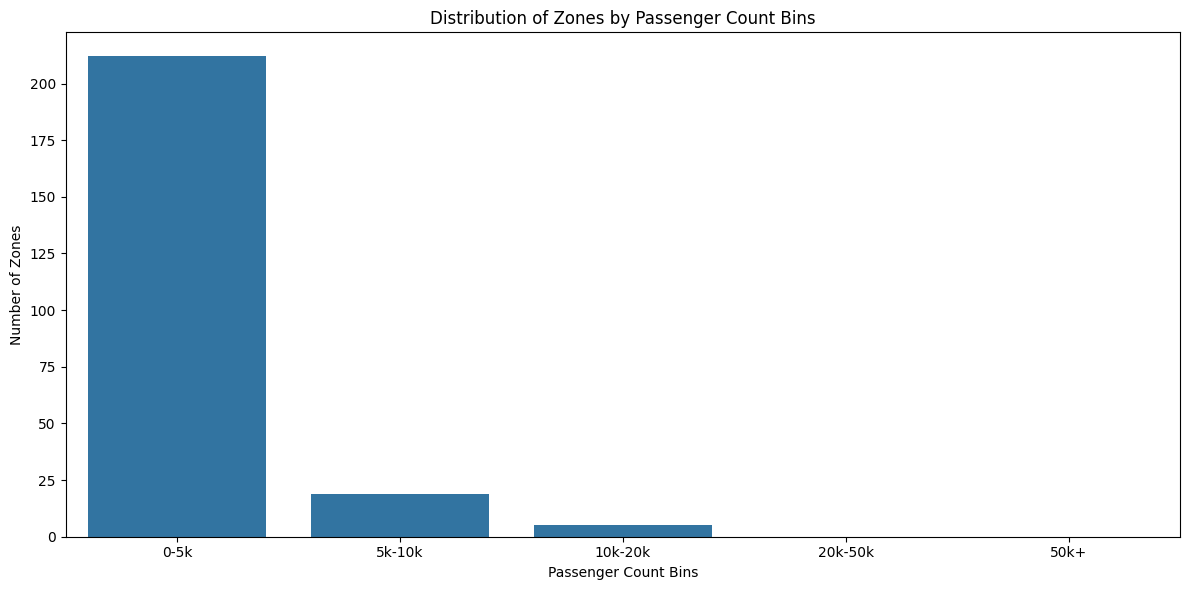

In [252]:
passenger_count_per_zone['passenger_count_bins'] = pd.cut(passenger_count_per_zone['passenger_count'], bins=[0, 5000, 10000, 20000, 50000, float('inf')], labels=['0-5k', '5k-10k', '10k-20k', '20k-50k', '50k+'])
binned_zones = passenger_count_per_zone.groupby('passenger_count_bins', observed = False)['zone'].count().reset_index(name='zone_count')
plt.figure(figsize=(12, 6))
sns.barplot(data=binned_zones, x="passenger_count_bins", y="zone_count")
plt.title("Distribution of Zones by Passenger Count Bins")
plt.xlabel("Passenger Count Bins")
plt.ylabel("Number of Zones")
plt.tight_layout()
plt.savefig(r'C:\Users\qaspe\Downloads/passengerbins.png')
plt.show()

In [254]:
# For a more detailed analysis, we can use the zones_with_trips GeoDataFrame
# Create a new column for the average passenger count in each zone.
average_passengers_per_zone = filtered_df2.groupby('zone')['passenger_count'].mean().reset_index()
zones_with_trips = pd.merge(zones_with_trips, average_passengers_per_zone, on='zone', how='left')
zones_with_trips = zones_with_trips.rename(columns={'passenger_count': 'avg_passenger_count'})

In [256]:
zones_with_trips['avg_passenger_count']

0      2.000000
1           NaN
2      1.000000
3      1.317460
4      1.000000
         ...   
258    1.000000
259    1.302326
260    1.522064
261    1.291836
262    1.323120
Name: avg_passenger_count, Length: 263, dtype: float64

Find out how often surcharges/extra charges are applied to understand their prevalance

**3.2.16** <font color = red>[5 marks]</font> <br>
Analyse the pickup/dropoff zones or times when extra charges are applied more frequently

In [258]:
# How often is each surcharge applied?
trips_with_extra_charges = filtered_df2[filtered_df2['extra'] > 0]
pick_up_zone_frequency = trips_with_extra_charges.groupby(['zone', 'LocationID'])['extra'].count().reset_index(name = 'extra_charge_frequency')
print('Frequency of Pickup Zones with Extra Charges:')
print(pick_up_zone_frequency.sort_values('extra_charge_frequency' , ascending = False).head(20))



Frequency of Pickup Zones with Extra Charges:
                             zone  LocationID  extra_charge_frequency
78              LaGuardia Airport         138                    9419
94                 Midtown Center         161                    8329
141         Upper East Side South         237                    7459
71                    JFK Airport         132                    7102
140         Upper East Side North         236                    6204
135     Times Sq/Theatre District         230                    6190
95                   Midtown East         162                    6177
81            Lincoln Square East         142                    5664
109  Penn Station/Madison Sq West         186                    5542
96                  Midtown North         163                    5021
46                   East Village          79                    5009
27                   Clinton East          48                    4884
102                   Murray Hill         17

In [260]:
trips_with_extra_charges = filtered_df2[filtered_df2['extra'] > 0]
drop_off_zone_frequency = trips_with_extra_charges.groupby(['zone', 'DOLocationID'])['extra'].count().reset_index(name = 'extra_charge_frequency')
print('Frequency of Dropoff Zones with Extra Charges:')
print(drop_off_zone_frequency.sort_values('extra_charge_frequency' , ascending = False).head(20))

Frequency of Dropoff Zones with Extra Charges:
                           zone  DOLocationID  extra_charge_frequency
6250      Upper East Side South         236.0                    1039
6125      Upper East Side North         237.0                     861
6251      Upper East Side South         237.0                     659
6124      Upper East Side North         236.0                     628
4189             Midtown Center         237.0                     545
3079          LaGuardia Airport         230.0                     522
4188             Midtown Center         236.0                     508
3457        Lincoln Square East         239.0                     438
6216      Upper East Side South         161.0                     421
6446      Upper West Side South         238.0                     412
3456        Lincoln Square East         238.0                     403
6407      Upper West Side South         142.0                     393
4325               Midtown East         236

## **4** Conclusion
<font color = red>[15 marks]</font> <br>

### **4.1** Final Insights and Recommendations
<font color = red>[15 marks]</font> <br>

Conclude your analyses here. Include all the outcomes you found based on the analysis.

Based on the insights, frame a concluding story explaining suitable parameters such as location, time of the day, day of the week etc. to be kept in mind while devising a strategy to meet customer demand and optimise supply.

**4.1.1** <font color = red>[5 marks]</font> <br>
Recommendations to optimize routing and dispatching based on demand patterns and operational inefficiencies

•	JFK Airport ,  East Village , West Village, Greenwich Village South, Times Sq/Theatre District . These are some of the top zones with highest pickup by hour as per analysis and hence more cabs can be deployed in these zones to increase the revenue for NYC taxi company. 
•	World Trade Center , Yorkville East , Yorkville West are the zones having very high passenger counts indicating high number of people using cabs in these zones and hence more cabs can be routes to these zones to have more trips 
•	261         1494
•	262         3765
•	263         5466   . These are three pick up LocationID showing a signficantly higher number of trips as compared to other pick up LocationID and hene routing or dispatching more cabs to these IDs can help increasing the trips and thus have more efficiency which directly would have positive impact on the revenue.
•	There is more traffic and more trips in the day hours and hence more cabs be routed as well. 
•	The data also indicates a higher trips in the week days as compared to weekends and hence company can consider operating more cabs . 
•	The average fare per mile is more in the morning time and especially around 2 pm and also even the day time revenue is high indicating a requirement to operate more cabs in the day. 
•	The trends for trips suggest indicate more trips on Saturday and hence more cabs be employed for picking up trips. 
•	Also if we analyze by the hours in a day then , there is a peak in trips at 18 hours and hence the company can try to increase the efficiency 
•	The operational efficiency and the cabs for picking up can be increased for the months of October , May and March as these months have higher trips as indicated by the data analysis.


**4.1.2** <font color = red>[5 marks]</font> <br>

Suggestions on strategically positioning cabs across different zones to make best use of insights uncovered by analysing trip trends across time, days and months.

For night time positioning 
•	The data indicates that the top pick up zones during night time are mainly JKF Airport , Clinton East , Lower East Side , Greenwich Village South Lower Manhattan, Williamsburg, East Village so more cabs can  be positioned in these zones to increase the night trips and thus growing the revenue. 
                                   For day time positioning 
•	Higher cabs be stationed and operationalized in the zones with high passenger counts and accordingly the revenue can be increased.
•	More cabs be positioned in more residential areas and boroughs 
•	In the evening time , cabs be positioned to mid town Manhattan areas where the picks ups are high in the evening.
•	On week days allocate more cabs to Penn Station, Wall Street, Midtown Manhattan.
•	Assign a fixed percentage of cabs to JKF airport due to the high pickups. 



**4.1.3** <font color = red>[5 marks]</font> <br>
Propose data-driven adjustments to the pricing strategy to maximize revenue while maintaining competitive rates with other vendors.

•	In terms of pricing strategy , company can decide on charging a congestion surcharge on the trip with busiest traffic routes and with highest speeds . Also higher fare amount for trips in the day to get maximum revenue. 
•	The times when the trips are very low especially in the night time please offer discounts to customers. 
•	Consider the those time when the trips are very low especially during weekends and can consider discount for weekends to consider encouraging more customers to take the taxi rides.
•	There is a very strong correlation between fare amount and tip amount and hence based on reaching a certain fare amount – a preset tip amount can be charged to the customer can be set and accordingly increase the revenue from the trip. 
•	From the data it indicates the Vendor 2 is charging the highest fare per mile which is peaking in the late afternoon during 15-18 hours and accordingly offer a high premium service and maintain the high fare being charged 
•	In case of Vendor 1 , it maintains a moderate and more stable fare across the day. Company can consider a surge pricing with maintaining a balanced fare charges per mile. 
•	Also vendor 6 charges the lowest fare per mile across all hours so encourage more customer to take rides in quiet hours where the trips are very less to have more revenue. 
•	Since credit cards are the most preferred payment type , possible discount on credit card can be offered of say about 3 to 5 %.
•	Can consider offering a subscription to customers with digital payments. 
•	During the busiest hours , company can consider offering a sur charge on digital payments. 
•	Since passenger counts do not have very strong correlation as per the heatmap hence rides can be same irrespective of the number of passengers taking the ride. 
•	For the benefit of customers don’t charge very high surcharge during peak traffic time . 
